In [59]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from sklearn.neighbors import NearestNeighbors
from itertools import cycle
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
from sklearn.cluster import KMeans
import torchvision.models as models
from torch.autograd import Variable
from sklearn.metrics import classification_report
from sklearn import preprocessing
from utils import build_knn_graph, label_return, plot_auc, print_auc, calculate_metrics_new, run_eval
from model_resnet_skin import Projection, Model_SKIN, CNN
from model_resnet_abide import Projection, Model_ABIDE, CNN
from model_resnet_pd import Projection, Model_PD, CNN
from losses import WeightedCrossEntropyLoss, contrastive_loss, info_loss, MGECLoss, SACLoss
import argparse
from data_handlder.load_dataset import dataloader
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import plot_roc_curve
import numpy as np
import matplotlib.pyplot as plt


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_fscore_support, jaccard_score


class ClassifierPipeline(object): 

    def __init__(self, classifier_dict):
        """
            Preprocessing should be done 
            Args: 
                dictionary of classifier, w its parameters
                number of cross-validation folds
        """
        self.classifier_dict = classifier_dict
    
    def fit(self, X, y, numfolds):
        """
            Fit k-fold cross-validated classifier, store model metrics & create ROC plot
            X: observation x features matrix
            y: list of labels
            folds: how many folds of cross-validation
        """
        self.conf_matrix = {}
        fig, ax = plt.subplots(figsize=(28,5), nrows=1, ncols=len(self.classifier_dict.keys()))

        for c, (classifier_name, classifier) in enumerate(self.classifier_dict.items()):   
            
            print(f'Running {classifier_name} classification')
        
            # store this fold's outputs
            k_accuracy = np.zeros((numfolds))
            conf_mat = np.zeros((2,2)) 

            # for roc plot
            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)

            cv = StratifiedKFold(n_splits=numfolds)  
            for k, (train, test) in enumerate(cv.split(X, y)):
                
                # Create a clone of the classifier for each cross-validation
                classifier_clone = clone(classifier)
                if "SVC" in classifier_name:
                    classifier_clone = CalibratedClassifierCV(classifier_clone)

                # fit model & predict
                classifier_clone.fit(X[train], y[train])
                predictions = classifier_clone.predict(X[test])

                # classifier metrics 
                k_accuracy[k] = classifier_clone.score(X[test], y[test])
                conf_mat = conf_mat + confusion_matrix(y[test], predictions) # sum across folds
                
                # ROC plot for this fold
                viz = plot_roc_curve(classifier_clone, X[test], y[test], name=f'ROC fold {k+1}', alpha=0.3, lw=1, ax=ax[c])
                
                # Store tpr and fpr values to calculate mean ROC at the end
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(viz.roc_auc)

            # Calculate mean ROC and plt  
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0 
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

            ax[c].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
            ax[c].plot(mean_fpr, mean_tpr, color='b',
                    label=f'Mean ROC (AUC={np.round(mean_auc, 2)} +/- {np.round(std_auc, 2)})',
                    lw=2, alpha=.8)
            ax[c].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=f'+/- 1 std. dev.')
            ax[c].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f'{classifier_name} ROC')
            ax[c].legend(loc="lower right")
    
            self.conf_matrix[classifier_name] = conf_mat

            # Print c.v. results
            print(f"{numfolds}-fold cross-validated accuracy: {np.round(np.mean(k_accuracy), 5)*100}%")
            print(k_accuracy)
            print()
            
            # train each classifier with full data
            classifier.fit(X, y)

In [18]:


def model_fit(X, y, model, numfolds):
    """
    Fit k-fold cross-validated classifier, store model metrics & create ROC plot
    X: observation x features matrix
    y: list of labels
    numfolds: how many folds of cross-validation
    """
    conf_matrix = {}
    fig, ax = plt.subplots(figsize=(28, 5), nrows=1)

    print(f'Running {classifier_name} classification')

    # store this fold's outputs
    k_accuracy = np.zeros((numfolds))
    conf_mat = np.zeros((2, 2))

    # for roc plot
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    cv = StratifiedKFold(n_splits=numfolds)
    for k, (train, test) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # classifier metrics
        k_accuracy[k] = model.score(X_test, y_test)
        conf_mat = conf_mat + confusion_matrix(y_test, predictions)  # sum across folds

        # ROC plot for this fold
        viz = plot_roc_curve(model, X_test, y_test, name=f'ROC fold {k + 1}', alpha=0.3, lw=1, ax=ax)

        # Store tpr and fpr values to calculate mean ROC at the end
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # Calculate mean ROC and plot
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f'Mean ROC (AUC={np.round(mean_auc, 2)} +/- {np.round(std_auc, 2)})',
            lw=2, alpha=.8)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=f'+/- 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f'{classifier_name} ROC')
    ax.legend(loc="lower right")

    conf_matrix[classifier_name] = conf_mat

    # Print c.v. results
    print(f"{numfolds}-fold cross-validated accuracy: {np.round(np.mean(k_accuracy), 5) * 100}%")
    print(k_accuracy)
    print()

    # Train the classifier with the full data
    model.fit(X, y)


In [23]:

def train_eval(datadir,skin_type, loss_select, model_select , dataset_choice ,category, epoch, n_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    torch.cuda.is_available()
    if model_select == 'resnet_18':
        model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # resnet = models.resnet18(pretrained=True)
    elif model_select == 'resnet_34':
         model_net = models.resnet34(pretrained=True)
    elif model_select == 'resnet_50':
        model_net = models.resnet50(pretrained=True)
    elif model_select == 'densenet':
         model_net = models.densenet121(pretrained=True)
        
    #resnet = models.alexnet(pretrained=True)
    
    model_net = model_net.to(device)
    # 将最后一层的输出维度修改为类别数目
    num_classes = 1024
    
    # num_features = model_net.fc.in_features #512 # Resnet
    num_features = model_net.classifier.in_features # Desnet101
    # import pdb;pdb.set_trace()
    # model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
    # model_net.fc = model_net.fc.to(device) #512 # Resnet
    model_net.classifier = nn.Linear(num_features, num_classes) #desnet

    image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)

    projection = Projection(262, 3)
    if datadir == 'skin':
        model = Model_SKIN(projection, model_net, n_classes).to(device)
    elif datadir == 'abide':
        model = Model_ABIDE(projection, model_net, n_classes).to(device)
    elif datadir == 'pd':
        model = Model_PD(projection, model_net, n_classes).to(device)

    class_weights = torch.full((1,n_classes),0.5).view(-1)
    criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

    if loss_select == 'Contrastive_loss':
         criterion2 = contrastive_loss

    elif loss_select == 'MGEC_loss':
        criterion2 = MGECLoss()
        
    elif loss_select == 'InfoNCE_loss':
        criterion2 = info_loss
        
    elif loss_select == 'SAC_loss':
        criterion2 = SACLoss()

    # criterion3 = loss_dependence
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    class_name = "Dag"
    n_epochs = epoch

    training_range = tqdm(range(n_epochs))

    for epoch in training_range:
        optimizer.zero_grad()
        # cnn_z  =  cnn_encoder(image_data)
        # 前向传播
        
        image_data_train = image_data_train.to(device)
        feature_data_train = feature_data_train.to(device)
        adj_train_img = adj_train_img.to(device)
        adj_f_knn_train = adj_f_knn_train.to(device)

        output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train)
         
        y = torch.tensor(label_return(dataset_choice, class_name, "train")).to(device)
        
        loss_ce1 = criterion1(output1, y)
        loss_ce2 = criterion1(output2, y)
        alpha = 0.4

        if loss_select == 'Contrastive_loss':
            adj = adj_train_img +  adj_f_knn_train
            diag = torch.diag(adj.sum(dim=1))
            loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
            loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra

        elif loss_select == 'MGEC_loss':
            adj = adj_train_img +  adj_f_knn_train
            diag = torch.diag(adj.sum(dim=1))
            loss_extra = criterion2(output1, output2, adj, diag )
            loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
            #loss = loss_extra

        elif loss_select == 'InfoNCE_loss':
            loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
            loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

        elif loss_select == 'SAC_loss':    
            adj = adj_train_img +  adj_f_knn_train
            diag = torch.diag(adj.sum(dim=1))
            loss_extra = criterion2(emb, adj)
            loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
        elif loss_select == 'only_CE':
            loss = loss_ce1 + loss_ce2


        loss.backward()
        optimizer.step()
        # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
        # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

    model.eval()
    with torch.no_grad():
        # import pdb;pdb.set_trace()
        image_data_test = image_data_test.to(device)
        test_feature_data = test_feature_data.to(device)
        adj_test_img = adj_test_img.to(device)
        adj_f_knn_test = adj_f_knn_test.to(device)
        
        test_output1, test_output2, emb  = model(image_data_test, test_feature_data , adj_test_img, adj_f_knn_test )

        # test_output1  = model(test_image_data, test_adjacency_matrix, adj_test_img )
        m = nn.Softmax(dim=1)
        # import pdb;pdb.set_trace()
        test_output = test_output1 + test_output2
    #     test_output = emb

        #z = test_output1 + test_output2
        
        #num_clusters = 3
        #kmeans = KMeans(n_clusters=num_clusters)

        #cluster_labels = kmeans.fit_predict(z.cpu().data.numpy())
        #cluster_labels = torch.tensor(cluster_labels,dtype=torch.int64).to(device)



        pred =  m(test_output).argmax(dim=1)
        #pred = cluster_labels
        # test_output = test_output.argmax(dim=1)
        
        
        # y_test = torch.empty(100).random_(2)
    #     y_test = torch.tensor(label_3_test).to(device)
        y_test = torch.from_numpy(label_return(dataset_choice ,class_name, "test")).to(device)

        # import pdb;pdb.set_trace()
        correct = (pred  == y_test).sum().item()
        accuracy = correct / len(y_test)
        
        
        import pdb;pdb.set_trace()
        print(f"++++Use {model_select} model+++")
        print(calculate_metrics_new(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
        print("Loss:", loss_select, "class_name",class_name,"Accuracy:", accuracy)
        print(classification_report(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
        if datadir == 'pd':
            accuracy, precision, recall, fscore, sensivity, specificity, nmi, ari = run_eval(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
            print("acc:",accuracy, "precision:", precision,"recall:", recall,"fscore:", fscore,"sensitivity:", sensivity,"specificity:", specificity, "nmi", nmi, "ari", ari)
            # plot_ROC(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, classes, skin_type, loss_select)
            # print_auc(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, category, skin_type, loss_select)

def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_data_dir', type=str, default='pd')
#     parser.add_argument('--skin_type', type=str, default='dermatology_images')
#     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
#     parser.add_argument('--model_select', type=str, default='densenet')
#     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
#     parser.add_argument('--dataset_choice', type=str, default='pd')
#     parser.add_argument('--category', type=str)
#     parser.add_argument('--n_epoch', type=int, default=300)
#     parser.add_argument('--n_classes', type=int, default=2)
    
#     args = parser.parse_args()

    img_data_dir = 'pd'
    skin_type = 'dermatology_images'
    losses_choice = 'Contrastive_loss'
    model_select = 'densenet'
    dataset_choice = 'pd'
    category = 'your_category'  # 设置正确的类别值
    n_epoch = 3
    n_classes = 2

    train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)
#     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


if __name__ == '__main__':
    main()


/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:00,  2.37it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.34it/s]

100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


> <ipython-input-23-3a4fa9d360af>(149)train_eval()
-> print(f"++++Use {model_select} model+++")
(Pdb) q


BdbQuit: 

In [60]:
def dataloader(datadir,skin_type):

    

    if datadir == 'pd':
        path_img = '/home/jding/Documents/PD_contrastive_research_0817/spect_513_data'+ '/'
        path_meta = '/home/jding/Documents/PD_contrastive_research_0817/spect_513_data' + '/' 
        coll = io.ImageCollection('/home/jding/Documents/PD_contrastive_research_0817/spect_513_data/spect_img_a2/*.jpg')

        #coll = io.ImageCollection(r'C:\Users\adm\SPECT_3_3\mask_three\*.jpg')
        #coll = io.ImageCollection(r'C:\Users\adm\SPECT_3_3\all_SPECT_RGB\*.jpg')
        raw_image = io.concatenate_images(coll)

        
        raw_meta = pd.read_csv(path_meta  + 'label_513.csv') 
        label_630_id = raw_meta[raw_meta['ID'] < 634]
        raw_data = raw_image[label_630_id['Python_ID']] / 255

        raw_data = torch.tensor(raw_data).transpose(1,3)
        # raw_data = torch.flatten(raw_data, start_dim=1)
        raw_data = np.array(raw_data)
        raw_patients_feature_412 = np.asarray(label_630_id.iloc[:,8:20])

        
        raw_image_train = raw_data[0:300]
        raw_image_test = raw_data[300:]
        
        # raw_image_train = np.load('/Users/test/Documents/Contrastive_PD/skin_dataset_ok/clinical_images/train_clinic_f_413.npy') /255
        # raw_image_test = np.load('/Users/test/Documents/Contrastive_PD/skin_dataset_ok/clinical_images/test_clinic_f_395.npy') /255
        

        raw_f_train = raw_patients_feature_412[0:300]
        raw_f_test = raw_patients_feature_412[300:]
        # raw_f_train = preprocessing.scale(raw_f_train )
        # raw_f_test = preprocessing.scale(raw_f_test )
        
        image_data_train = raw_image_train 
        feature_data_train = raw_f_train 
        
        
        image_data_train = torch.from_numpy(image_data_train ).float() #torch.Size([413, 128, 128, 3])
        
        
        feature_data_train = torch.from_numpy(feature_data_train).float()

        image_data_flatten = torch.flatten(image_data_train, start_dim=1)

        # import pdb;pdb.set_trace()
        adj_train_img = build_knn_graph(image_data_flatten,300).float()
        
        # adj_train_img = kneighbors_graph(np.array(image_data_flatten), 200, mode='connectivity', include_self=True).toarray()

        
        
        # adj_train_img = torch.from_numpy(adj_train_img).float()
        
        
        image_data_test = torch.from_numpy(raw_image_test ).float()
    
        data_features_test = raw_f_test 
        test_feature_data = torch.from_numpy(data_features_test).float()

    # 创建测试用的邻接矩阵（这里假设所有病人之间都有连接）
    # test_adjacency_matrix = torch.ones((100, 100))


    ## testing image adj
        image_data_test_flatten = torch.flatten(image_data_test, start_dim=1)
        # image_data_test_flatten = image_data_test
  
        # adj_test_img = kneighbors_graph(np.array(image_data_test_flatten), 200, mode='connectivity', include_self=True).toarray()
        
        adj_test_img = build_knn_graph(image_data_test_flatten, 80).float() #[104, 104]

        
        adj_f_knn_train =  build_knn_graph(raw_f_train, 300).float()
        
        # adj_f_knn_train = adj_f_knn_train.toarray()
        # adj_f_knn_train = torch.from_numpy(adj_f_knn_train).float()
        # adj_f_knn_test = kneighbors_graph(np.array(raw_f_test), 300, mode='connectivity', include_self=True)
        adj_f_knn_test = build_knn_graph(raw_f_test, 80).float()
        # import pdb;pdb.set_trace()

       
    return image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test


# 修改後dataloader

In [70]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from sklearn.neighbors import NearestNeighbors
from itertools import cycle
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
from sklearn.cluster import KMeans
import torchvision.models as models
from torch.autograd import Variable
from sklearn.metrics import classification_report
from sklearn import preprocessing
from utils import build_knn_graph, label_return, plot_auc, print_auc, calculate_metrics_new, run_eval
from model_resnet_skin import Projection, Model_SKIN, CNN
from model_resnet_abide import Projection, Model_ABIDE, CNN
from model_resnet_pd import Projection, Model_PD, CNN
from losses import WeightedCrossEntropyLoss, contrastive_loss, info_loss, MGECLoss, SACLoss
import argparse
from data_handlder.load_dataset import dataloader
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import plot_roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_fscore_support, jaccard_score


from sklearn.model_selection import StratifiedKFold
from skimage import data_dir,io,color

def dataloader_cv(datadir, skin_type, num_folds=5):
    
    if datadir == 'pd':
        path_img = '/home/jding/Documents/PD_contrastive_research_0817/spect_513_data' + '/'
        path_meta = '/home/jding/Documents/PD_contrastive_research_0817/spect_513_data' + '/'
        coll = io.ImageCollection('/home/jding/Documents/PD_contrastive_research_0817/spect_513_data/spect_img_a2/*.jpg')
        
        raw_image = io.concatenate_images(coll)

        raw_meta = pd.read_csv(path_meta + 'label_513.csv')
        label_630_id = raw_meta[raw_meta['ID'] < 634]
        raw_data = raw_image[label_630_id['Python_ID']] / 255
        raw_data = torch.tensor(raw_data).transpose(1, 3)
        raw_data = np.array(raw_data)
        raw_patients_feature_412 = np.asarray(label_630_id.iloc[:, 8:20])
        
#         import pdb;pdb.set_trace()
        # 创建 StratifiedKFold 对象
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

        image_data_train_list = []
        feature_data_train_list = []
        adj_train_img_list = []
        adj_f_knn_train_list = []
        image_data_test_list = []
        test_feature_data_list = []
        adj_test_img_list = []
        adj_f_knn_test_list = []
        y_train_list = []
        y_test_list = []
#         import pdb;pdb.set_trace()
        for train_index, test_index in skf.split(raw_data, label_630_id['Label_2'].values):
            y_train = label_630_id['Label_2'].values[train_index]
            y_test = label_630_id['Label_2'].values[test_index]
            # 根据每个折叠的索引提取相应的训练和测试数据
            raw_image_train = raw_data[train_index]
            raw_image_test = raw_data[test_index]

            raw_f_train = raw_patients_feature_412[train_index]
            raw_f_test = raw_patients_feature_412[test_index]

            image_data_train = torch.from_numpy(raw_image_train).float()
            feature_data_train = torch.from_numpy(raw_f_train).float()
            image_data_flatten = torch.flatten(image_data_train, start_dim=1)
            adj_train_img = build_knn_graph(image_data_flatten, len(train_index)).float()

            image_data_test = torch.from_numpy(raw_image_test).float()
            data_features_test = raw_f_test
            test_feature_data = torch.from_numpy(data_features_test).float()

            image_data_test_flatten = torch.flatten(image_data_test, start_dim=1)
            adj_test_img = build_knn_graph(image_data_test_flatten, len(test_index)).float()
            adj_f_knn_train = build_knn_graph(raw_f_train, len(train_index)).float()
            adj_f_knn_test = build_knn_graph(raw_f_test, len(test_index)).float()

            # 将每个折叠的数据添加到列表中
            y_train_list.append(y_train)
            y_test_list.append(y_test)
            image_data_train_list.append(image_data_train)
            feature_data_train_list.append(feature_data_train)
            adj_train_img_list.append(adj_train_img)
            adj_f_knn_train_list.append(adj_f_knn_train)
            image_data_test_list.append(image_data_test)
            test_feature_data_list.append(test_feature_data)
            adj_test_img_list.append(adj_test_img)
            adj_f_knn_test_list.append(adj_f_knn_test)

    return image_data_train_list, feature_data_train_list, adj_train_img_list, \
        adj_f_knn_train_list, image_data_test_list, test_feature_data_list, \
        adj_test_img_list, adj_f_knn_test_list, y_train_list ,y_test_list

In [33]:
y_train_list, \
y_test_list, \
image_data_train,\
feature_data_train, \
adj_train_img, \
adj_f_knn_train, image_data_test, test_feature_data, \
adj_test_img, adj_f_knn_test = dataloader_cv('pd', 'dermatology_images', num_folds=5)

In [31]:
y_train_list

[array([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 

In [24]:
len(mage_data_train_list)

5

In [25]:
mage_data_train_list[0].shape

torch.Size([329, 3, 128, 128])

# Cross Validation













  0%|          | 0/300 [00:00<?, ?it/s]

Fold 1/5:














  0%|          | 1/300 [00:00<02:15,  2.20it/s]











  1%|          | 2/300 [00:00<02:16,  2.18it/s]











  1%|          | 3/300 [00:01<02:15,  2.19it/s]











  1%|▏         | 4/300 [00:01<02:12,  2.23it/s]











  2%|▏         | 5/300 [00:02<02:10,  2.26it/s]











  2%|▏         | 6/300 [00:02<02:11,  2.23it/s]











  2%|▏         | 7/300 [00:03<02:09,  2.26it/s]











  3%|▎         | 8/300 [00:03<02:08,  2.28it/s]











  3%|▎         | 9/300 [00:03<02:06,  2.29it/s]











  3%|▎         | 10/300 [00:04<02:05,  2.31it/s]











  4%|▎         | 11/300 [00:04<02:05,  2.31it/s]











  4%|▍         | 12/300 [00:05<02:04,  2.31it/s]











  4%|▍         | 13/300 [00:05<02:03,  2.31it/s]











  5%|▍         | 14/300 [00:06<02:05,  2.28it/s]











  5%|▌         | 15/300 [00:06<02:05,  2.28it/s]











  5%|▌         | 16/300 [00:07<02:06,  2.25it/s]











  6%|▌         | 17/300 [00:07<02:04,

 29%|██▊       | 86/300 [00:37<01:32,  2.33it/s]











 29%|██▉       | 87/300 [00:37<01:31,  2.33it/s]











 29%|██▉       | 88/300 [00:38<01:30,  2.33it/s]











 30%|██▉       | 89/300 [00:38<01:30,  2.33it/s]











 30%|███       | 90/300 [00:38<01:30,  2.32it/s]











 30%|███       | 91/300 [00:39<01:29,  2.33it/s]











 31%|███       | 92/300 [00:39<01:29,  2.33it/s]











 31%|███       | 93/300 [00:40<01:29,  2.32it/s]











 31%|███▏      | 94/300 [00:40<01:28,  2.32it/s]











 32%|███▏      | 95/300 [00:41<01:28,  2.33it/s]











 32%|███▏      | 96/300 [00:41<01:27,  2.33it/s]











 32%|███▏      | 97/300 [00:41<01:27,  2.33it/s]











 33%|███▎      | 98/300 [00:42<01:26,  2.33it/s]











 33%|███▎      | 99/300 [00:42<01:28,  2.28it/s]











 33%|███▎      | 100/300 [00:43<01:27,  2.29it/s]











 34%|███▎      | 101/300 [00:43<01:26,  2.30it/s]











 34%|███▍      | 102/300 [00:44<01:26,

 57%|█████▋    | 170/300 [01:14<00:58,  2.23it/s]











 57%|█████▋    | 171/300 [01:14<00:57,  2.24it/s]











 57%|█████▋    | 172/300 [01:14<00:56,  2.25it/s]











 58%|█████▊    | 173/300 [01:15<00:57,  2.21it/s]











 58%|█████▊    | 174/300 [01:15<00:56,  2.22it/s]











 58%|█████▊    | 175/300 [01:16<00:55,  2.24it/s]











 59%|█████▊    | 176/300 [01:16<00:55,  2.25it/s]











 59%|█████▉    | 177/300 [01:17<00:54,  2.25it/s]











 59%|█████▉    | 178/300 [01:17<00:54,  2.25it/s]











 60%|█████▉    | 179/300 [01:18<00:54,  2.22it/s]











 60%|██████    | 180/300 [01:18<00:53,  2.24it/s]











 60%|██████    | 181/300 [01:18<00:53,  2.24it/s]











 61%|██████    | 182/300 [01:19<00:52,  2.25it/s]











 61%|██████    | 183/300 [01:19<00:51,  2.26it/s]











 61%|██████▏   | 184/300 [01:20<00:51,  2.26it/s]











 62%|██████▏   | 185/300 [01:20<00:51,  2.25it/s]











 62%|██████▏   | 186/300

 85%|████████▍ | 254/300 [01:52<00:21,  2.17it/s]











 85%|████████▌ | 255/300 [01:52<00:20,  2.17it/s]











 85%|████████▌ | 256/300 [01:52<00:20,  2.17it/s]











 86%|████████▌ | 257/300 [01:53<00:19,  2.16it/s]











 86%|████████▌ | 258/300 [01:53<00:19,  2.13it/s]











 86%|████████▋ | 259/300 [01:54<00:19,  2.15it/s]











 87%|████████▋ | 260/300 [01:54<00:18,  2.15it/s]











 87%|████████▋ | 261/300 [01:55<00:18,  2.15it/s]











 87%|████████▋ | 262/300 [01:55<00:17,  2.16it/s]











 88%|████████▊ | 263/300 [01:56<00:17,  2.16it/s]











 88%|████████▊ | 264/300 [01:56<00:16,  2.15it/s]











 88%|████████▊ | 265/300 [01:57<00:16,  2.14it/s]











 89%|████████▊ | 266/300 [01:57<00:15,  2.14it/s]











 89%|████████▉ | 267/300 [01:58<00:15,  2.15it/s]











 89%|████████▉ | 268/300 [01:58<00:14,  2.16it/s]











 90%|████████▉ | 269/300 [01:58<00:14,  2.16it/s]











 90%|█████████ | 270/300

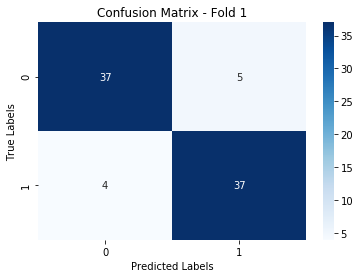

<Figure size 432x288 with 0 Axes>

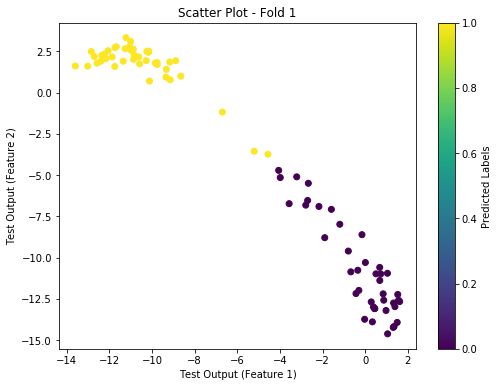













  0%|          | 0/299 [00:00<?, ?it/s]

++++Use resnet_18 model+++
starting!!!-----------------------------------------------
Accuracy: 0.891566265060241
Sensitivity: 0.9024390243902439
Specificity: 0.8809523809523809
Precision: 0.8809523809523809
Ending!!!------------------------------------------------------
(0.9024390243902439, 0.8809523809523809)
Loss: Contrastive_loss class_name Dag Accuracy: 0.891566265060241
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        42
           1       0.88      0.90      0.89        41

    accuracy                           0.89        83
   macro avg       0.89      0.89      0.89        83
weighted avg       0.89      0.89      0.89        83

ARI: 0.6085238378516189
acc: 0.891566265060241 precision: 0.8809523809523809 recall: 0.9024390243902439 fscore: 0.891566265060241 sensitivity: 0.9024390243902439 specificity: 0.8809523809523809 nmi 0.5056376989259891 ari 0.6085238378516189
Fold 2/5:














  0%|          | 1/299 [00:00<02:23,  2.08it/s]











  1%|          | 2/299 [00:00<02:20,  2.11it/s]











  1%|          | 3/299 [00:01<02:19,  2.13it/s]











  1%|▏         | 4/299 [00:01<02:18,  2.13it/s]











  2%|▏         | 5/299 [00:02<02:17,  2.14it/s]











  2%|▏         | 6/299 [00:02<02:16,  2.15it/s]











  2%|▏         | 7/299 [00:03<02:16,  2.14it/s]











  3%|▎         | 8/299 [00:03<02:17,  2.12it/s]











  3%|▎         | 9/299 [00:04<02:15,  2.13it/s]











  3%|▎         | 10/299 [00:04<02:15,  2.14it/s]











  4%|▎         | 11/299 [00:05<02:16,  2.11it/s]











  4%|▍         | 12/299 [00:05<02:14,  2.13it/s]











  4%|▍         | 13/299 [00:06<02:13,  2.14it/s]











  5%|▍         | 14/299 [00:06<02:13,  2.14it/s]











  5%|▌         | 15/299 [00:07<02:12,  2.15it/s]











  5%|▌         | 16/299 [00:07<02:11,  2.15it/s]











  6%|▌         | 17/299 [00:07<02:10,

 29%|██▉       | 86/299 [00:40<01:40,  2.13it/s]











 29%|██▉       | 87/299 [00:40<01:39,  2.14it/s]











 29%|██▉       | 88/299 [00:40<01:40,  2.10it/s]











 30%|██▉       | 89/299 [00:41<01:40,  2.10it/s]











 30%|███       | 90/299 [00:41<01:39,  2.10it/s]











 30%|███       | 91/299 [00:42<01:38,  2.11it/s]











 31%|███       | 92/299 [00:42<01:38,  2.11it/s]











 31%|███       | 93/299 [00:43<01:37,  2.11it/s]











 31%|███▏      | 94/299 [00:43<01:36,  2.11it/s]











 32%|███▏      | 95/299 [00:44<01:36,  2.12it/s]











 32%|███▏      | 96/299 [00:44<01:35,  2.12it/s]











 32%|███▏      | 97/299 [00:45<01:35,  2.12it/s]











 33%|███▎      | 98/299 [00:45<01:36,  2.09it/s]











 33%|███▎      | 99/299 [00:46<01:34,  2.11it/s]











 33%|███▎      | 100/299 [00:46<01:34,  2.10it/s]











 34%|███▍      | 101/299 [00:47<01:34,  2.11it/s]











 34%|███▍      | 102/299 [00:47<01:33,

 57%|█████▋    | 170/299 [01:19<01:05,  1.98it/s]











 57%|█████▋    | 171/299 [01:20<01:04,  1.98it/s]











 58%|█████▊    | 172/299 [01:20<01:03,  2.00it/s]











 58%|█████▊    | 173/299 [01:21<01:01,  2.05it/s]











 58%|█████▊    | 174/299 [01:21<01:00,  2.08it/s]











 59%|█████▊    | 175/299 [01:22<00:59,  2.09it/s]











 59%|█████▉    | 176/299 [01:22<00:58,  2.11it/s]











 59%|█████▉    | 177/299 [01:22<00:57,  2.11it/s]











 60%|█████▉    | 178/299 [01:23<00:57,  2.12it/s]











 60%|█████▉    | 179/299 [01:23<00:56,  2.12it/s]











 60%|██████    | 180/299 [01:24<00:55,  2.13it/s]











 61%|██████    | 181/299 [01:24<00:55,  2.14it/s]











 61%|██████    | 182/299 [01:25<00:54,  2.14it/s]











 61%|██████    | 183/299 [01:25<00:54,  2.14it/s]











 62%|██████▏   | 184/299 [01:26<00:53,  2.14it/s]











 62%|██████▏   | 185/299 [01:26<00:53,  2.13it/s]











 62%|██████▏   | 186/299

 85%|████████▍ | 254/299 [01:59<00:21,  2.08it/s]











 85%|████████▌ | 255/299 [01:59<00:21,  2.09it/s]











 86%|████████▌ | 256/299 [02:00<00:20,  2.10it/s]











 86%|████████▌ | 257/299 [02:00<00:20,  2.07it/s]











 86%|████████▋ | 258/299 [02:01<00:19,  2.09it/s]











 87%|████████▋ | 259/299 [02:01<00:19,  2.10it/s]











 87%|████████▋ | 260/299 [02:02<00:18,  2.10it/s]











 87%|████████▋ | 261/299 [02:02<00:18,  2.11it/s]











 88%|████████▊ | 262/299 [02:03<00:17,  2.11it/s]











 88%|████████▊ | 263/299 [02:03<00:16,  2.12it/s]











 88%|████████▊ | 264/299 [02:03<00:16,  2.12it/s]











 89%|████████▊ | 265/299 [02:04<00:15,  2.13it/s]











 89%|████████▉ | 266/299 [02:04<00:15,  2.13it/s]











 89%|████████▉ | 267/299 [02:05<00:15,  2.13it/s]











 90%|████████▉ | 268/299 [02:05<00:14,  2.13it/s]











 90%|████████▉ | 269/299 [02:06<00:14,  2.10it/s]











 90%|█████████ | 270/299

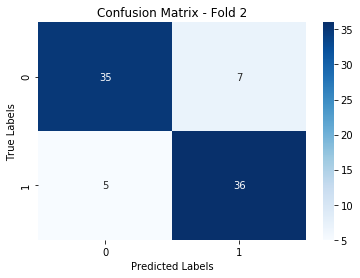

<Figure size 432x288 with 0 Axes>

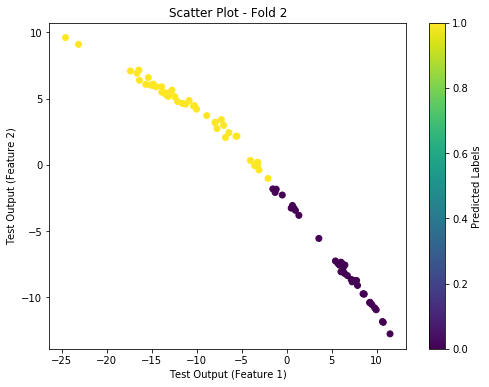













  0%|          | 0/298 [00:00<?, ?it/s]

++++Use resnet_18 model+++
starting!!!-----------------------------------------------
Accuracy: 0.8554216867469879
Sensitivity: 0.8780487804878049
Specificity: 0.8333333333333334
Precision: 0.8372093023255814
Ending!!!------------------------------------------------------
(0.8780487804878049, 0.8333333333333334)
Loss: Contrastive_loss class_name Dag Accuracy: 0.8554216867469879
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        42
           1       0.84      0.88      0.86        41

    accuracy                           0.86        83
   macro avg       0.86      0.86      0.86        83
weighted avg       0.86      0.86      0.86        83

ARI: 0.49919975071880796
acc: 0.8554216867469879 precision: 0.8372093023255814 recall: 0.8780487804878049 fscore: 0.8571428571428571 sensitivity: 0.8780487804878049 specificity: 0.8333333333333334 nmi 0.40609375125826225 ari 0.49919975071880796
Fold 3/5:














  0%|          | 1/298 [00:00<02:25,  2.05it/s]











  1%|          | 2/298 [00:00<02:26,  2.02it/s]











  1%|          | 3/298 [00:01<02:23,  2.06it/s]











  1%|▏         | 4/298 [00:01<02:24,  2.04it/s]











  2%|▏         | 5/298 [00:02<02:22,  2.06it/s]











  2%|▏         | 6/298 [00:02<02:20,  2.08it/s]











  2%|▏         | 7/298 [00:03<02:19,  2.09it/s]











  3%|▎         | 8/298 [00:03<02:20,  2.07it/s]











  3%|▎         | 9/298 [00:04<02:18,  2.08it/s]











  3%|▎         | 10/298 [00:04<02:17,  2.09it/s]











  4%|▎         | 11/298 [00:05<02:16,  2.10it/s]











  4%|▍         | 12/298 [00:05<02:15,  2.11it/s]











  4%|▍         | 13/298 [00:06<02:14,  2.11it/s]











  5%|▍         | 14/298 [00:06<02:14,  2.12it/s]











  5%|▌         | 15/298 [00:07<02:13,  2.12it/s]











  5%|▌         | 16/298 [00:07<02:12,  2.12it/s]











  6%|▌         | 17/298 [00:08<02:12,

 29%|██▉       | 86/298 [00:41<01:42,  2.07it/s]











 29%|██▉       | 87/298 [00:41<01:41,  2.07it/s]











 30%|██▉       | 88/298 [00:42<01:40,  2.09it/s]











 30%|██▉       | 89/298 [00:42<01:40,  2.07it/s]











 30%|███       | 90/298 [00:43<01:39,  2.09it/s]











 31%|███       | 91/298 [00:43<01:39,  2.09it/s]











 31%|███       | 92/298 [00:44<01:38,  2.08it/s]











 31%|███       | 93/298 [00:44<01:39,  2.07it/s]











 32%|███▏      | 94/298 [00:45<01:39,  2.04it/s]











 32%|███▏      | 95/298 [00:45<01:38,  2.05it/s]











 32%|███▏      | 96/298 [00:46<01:37,  2.07it/s]











 33%|███▎      | 97/298 [00:46<01:37,  2.07it/s]











 33%|███▎      | 98/298 [00:47<01:36,  2.07it/s]











 33%|███▎      | 99/298 [00:47<01:35,  2.07it/s]











 34%|███▎      | 100/298 [00:48<01:35,  2.07it/s]











 34%|███▍      | 101/298 [00:48<01:35,  2.07it/s]











 34%|███▍      | 102/298 [00:49<01:36,

 57%|█████▋    | 170/298 [01:22<01:02,  2.05it/s]











 57%|█████▋    | 171/298 [01:22<01:02,  2.03it/s]











 58%|█████▊    | 172/298 [01:23<01:01,  2.04it/s]











 58%|█████▊    | 173/298 [01:23<01:00,  2.06it/s]











 58%|█████▊    | 174/298 [01:24<00:59,  2.08it/s]











 59%|█████▊    | 175/298 [01:24<00:59,  2.08it/s]











 59%|█████▉    | 176/298 [01:25<00:58,  2.08it/s]











 59%|█████▉    | 177/298 [01:25<00:58,  2.08it/s]











 60%|█████▉    | 178/298 [01:26<00:57,  2.08it/s]











 60%|██████    | 179/298 [01:26<00:56,  2.09it/s]











 60%|██████    | 180/298 [01:27<00:56,  2.10it/s]











 61%|██████    | 181/298 [01:27<00:55,  2.10it/s]











 61%|██████    | 182/298 [01:27<00:55,  2.10it/s]











 61%|██████▏   | 183/298 [01:28<00:55,  2.07it/s]











 62%|██████▏   | 184/298 [01:28<00:54,  2.08it/s]











 62%|██████▏   | 185/298 [01:29<00:54,  2.08it/s]











 62%|██████▏   | 186/298

 85%|████████▌ | 254/298 [02:02<00:21,  2.09it/s]











 86%|████████▌ | 255/298 [02:03<00:20,  2.06it/s]











 86%|████████▌ | 256/298 [02:03<00:20,  2.07it/s]











 86%|████████▌ | 257/298 [02:04<00:19,  2.08it/s]











 87%|████████▋ | 258/298 [02:04<00:19,  2.07it/s]











 87%|████████▋ | 259/298 [02:05<00:18,  2.08it/s]











 87%|████████▋ | 260/298 [02:05<00:18,  2.09it/s]











 88%|████████▊ | 261/298 [02:06<00:17,  2.09it/s]











 88%|████████▊ | 262/298 [02:06<00:17,  2.09it/s]











 88%|████████▊ | 263/298 [02:06<00:16,  2.07it/s]











 89%|████████▊ | 264/298 [02:07<00:16,  2.08it/s]











 89%|████████▉ | 265/298 [02:07<00:15,  2.08it/s]











 89%|████████▉ | 266/298 [02:08<00:15,  2.08it/s]











 90%|████████▉ | 267/298 [02:08<00:14,  2.08it/s]











 90%|████████▉ | 268/298 [02:09<00:14,  2.09it/s]











 90%|█████████ | 269/298 [02:09<00:13,  2.09it/s]











 91%|█████████ | 270/298

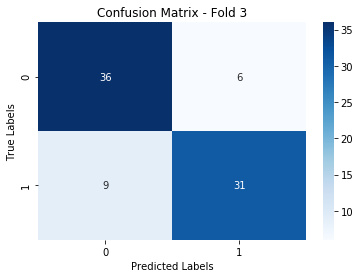

<Figure size 432x288 with 0 Axes>

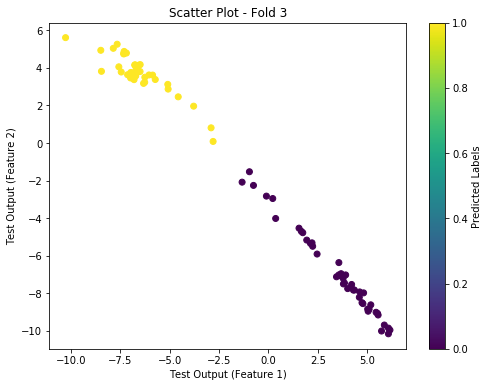













  0%|          | 0/297 [00:00<?, ?it/s]

++++Use resnet_18 model+++
starting!!!-----------------------------------------------
Accuracy: 0.8170731707317073
Sensitivity: 0.775
Specificity: 0.8571428571428571
Precision: 0.8378378378378378
Ending!!!------------------------------------------------------
(0.775, 0.8571428571428571)
Loss: Contrastive_loss class_name Dag Accuracy: 0.8170731707317073
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        42
           1       0.84      0.78      0.81        40

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82

ARI: 0.3947413518740666
acc: 0.8170731707317073 precision: 0.8378378378378378 recall: 0.775 fscore: 0.8051948051948052 sensitivity: 0.775 specificity: 0.8571428571428571 nmi 0.3160096324868234 ari 0.3947413518740666
Fold 4/5:














  0%|          | 1/297 [00:00<02:18,  2.14it/s]











  1%|          | 2/297 [00:00<02:18,  2.12it/s]











  1%|          | 3/297 [00:01<02:18,  2.12it/s]











  1%|▏         | 4/297 [00:01<02:18,  2.11it/s]











  2%|▏         | 5/297 [00:02<02:18,  2.11it/s]











  2%|▏         | 6/297 [00:02<02:20,  2.07it/s]











  2%|▏         | 7/297 [00:03<02:19,  2.08it/s]











  3%|▎         | 8/297 [00:03<02:18,  2.08it/s]











  3%|▎         | 9/297 [00:04<02:18,  2.08it/s]











  3%|▎         | 10/297 [00:04<02:17,  2.08it/s]











  4%|▎         | 11/297 [00:05<02:17,  2.09it/s]











  4%|▍         | 12/297 [00:05<02:16,  2.09it/s]











  4%|▍         | 13/297 [00:06<02:18,  2.06it/s]











  5%|▍         | 14/297 [00:06<02:16,  2.07it/s]











  5%|▌         | 15/297 [00:07<02:15,  2.07it/s]











  5%|▌         | 16/297 [00:07<02:15,  2.08it/s]











  6%|▌         | 17/297 [00:08<02:14,

 29%|██▉       | 86/297 [00:41<01:40,  2.09it/s]











 29%|██▉       | 87/297 [00:41<01:40,  2.09it/s]











 30%|██▉       | 88/297 [00:42<01:40,  2.09it/s]











 30%|██▉       | 89/297 [00:42<01:39,  2.09it/s]











 30%|███       | 90/297 [00:43<01:39,  2.09it/s]











 31%|███       | 91/297 [00:43<01:39,  2.08it/s]











 31%|███       | 92/297 [00:44<01:38,  2.08it/s]











 31%|███▏      | 93/297 [00:44<01:37,  2.09it/s]











 32%|███▏      | 94/297 [00:44<01:36,  2.09it/s]











 32%|███▏      | 95/297 [00:45<01:36,  2.10it/s]











 32%|███▏      | 96/297 [00:45<01:35,  2.10it/s]











 33%|███▎      | 97/297 [00:46<01:35,  2.10it/s]











 33%|███▎      | 98/297 [00:46<01:34,  2.10it/s]











 33%|███▎      | 99/297 [00:47<01:34,  2.10it/s]











 34%|███▎      | 100/297 [00:47<01:34,  2.08it/s]











 34%|███▍      | 101/297 [00:48<01:33,  2.09it/s]











 34%|███▍      | 102/297 [00:48<01:33,

 57%|█████▋    | 170/297 [01:21<01:01,  2.08it/s]











 58%|█████▊    | 171/297 [01:22<01:00,  2.08it/s]











 58%|█████▊    | 172/297 [01:22<01:00,  2.08it/s]











 58%|█████▊    | 173/297 [01:23<00:59,  2.08it/s]











 59%|█████▊    | 174/297 [01:23<00:59,  2.08it/s]











 59%|█████▉    | 175/297 [01:24<00:58,  2.08it/s]











 59%|█████▉    | 176/297 [01:24<00:59,  2.05it/s]











 60%|█████▉    | 177/297 [01:25<00:58,  2.05it/s]











 60%|█████▉    | 178/297 [01:25<00:57,  2.07it/s]











 60%|██████    | 179/297 [01:26<00:56,  2.07it/s]











 61%|██████    | 180/297 [01:26<00:56,  2.05it/s]











 61%|██████    | 181/297 [01:27<00:56,  2.06it/s]











 61%|██████▏   | 182/297 [01:27<00:55,  2.07it/s]











 62%|██████▏   | 183/297 [01:28<00:54,  2.08it/s]











 62%|██████▏   | 184/297 [01:28<00:54,  2.08it/s]











 62%|██████▏   | 185/297 [01:28<00:53,  2.08it/s]











 63%|██████▎   | 186/297

 86%|████████▌ | 254/297 [02:02<00:20,  2.09it/s]











 86%|████████▌ | 255/297 [02:02<00:20,  2.09it/s]











 86%|████████▌ | 256/297 [02:03<00:19,  2.09it/s]











 87%|████████▋ | 257/297 [02:03<00:19,  2.09it/s]











 87%|████████▋ | 258/297 [02:04<00:18,  2.09it/s]











 87%|████████▋ | 259/297 [02:04<00:18,  2.09it/s]











 88%|████████▊ | 260/297 [02:05<00:17,  2.09it/s]











 88%|████████▊ | 261/297 [02:05<00:17,  2.09it/s]











 88%|████████▊ | 262/297 [02:06<00:16,  2.09it/s]











 89%|████████▊ | 263/297 [02:06<00:16,  2.09it/s]











 89%|████████▉ | 264/297 [02:07<00:15,  2.09it/s]











 89%|████████▉ | 265/297 [02:07<00:15,  2.09it/s]











 90%|████████▉ | 266/297 [02:07<00:14,  2.09it/s]











 90%|████████▉ | 267/297 [02:08<00:14,  2.09it/s]











 90%|█████████ | 268/297 [02:08<00:13,  2.08it/s]











 91%|█████████ | 269/297 [02:09<00:13,  2.08it/s]











 91%|█████████ | 270/297

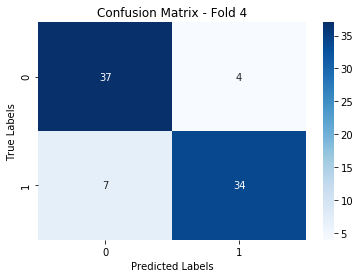

<Figure size 432x288 with 0 Axes>

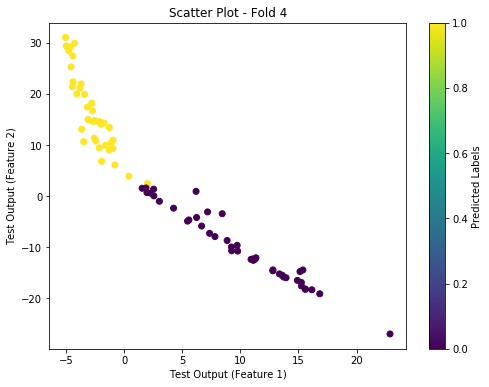













  0%|          | 0/296 [00:00<?, ?it/s]

++++Use resnet_18 model+++
starting!!!-----------------------------------------------
Accuracy: 0.8658536585365854
Sensitivity: 0.8292682926829268
Specificity: 0.9024390243902439
Precision: 0.8947368421052632
Ending!!!------------------------------------------------------
(0.8292682926829268, 0.9024390243902439)
Loss: Contrastive_loss class_name Dag Accuracy: 0.8658536585365854
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        41
           1       0.89      0.83      0.86        41

    accuracy                           0.87        82
   macro avg       0.87      0.87      0.87        82
weighted avg       0.87      0.87      0.87        82

ARI: 0.5296195227862501
acc: 0.8658536585365854 precision: 0.8947368421052632 recall: 0.8292682926829268 fscore: 0.8607594936708861 sensitivity: 0.8292682926829268 specificity: 0.9024390243902439 nmi 0.43668252436277727 ari 0.5296195227862501
Fold 5/5:














  0%|          | 1/296 [00:00<02:19,  2.12it/s]











  1%|          | 2/296 [00:00<02:19,  2.10it/s]











  1%|          | 3/296 [00:01<02:19,  2.10it/s]











  1%|▏         | 4/296 [00:01<02:20,  2.08it/s]











  2%|▏         | 5/296 [00:02<02:19,  2.08it/s]











  2%|▏         | 6/296 [00:02<02:20,  2.06it/s]











  2%|▏         | 7/296 [00:03<02:19,  2.07it/s]











  3%|▎         | 8/296 [00:03<02:19,  2.07it/s]











  3%|▎         | 9/296 [00:04<02:18,  2.07it/s]











  3%|▎         | 10/296 [00:04<02:18,  2.07it/s]











  4%|▎         | 11/296 [00:05<02:17,  2.07it/s]











  4%|▍         | 12/296 [00:05<02:17,  2.07it/s]











  4%|▍         | 13/296 [00:06<02:16,  2.07it/s]











  5%|▍         | 14/296 [00:06<02:15,  2.08it/s]











  5%|▌         | 15/296 [00:07<02:15,  2.07it/s]











  5%|▌         | 16/296 [00:07<02:15,  2.07it/s]











  6%|▌         | 17/296 [00:08<02:15,

 29%|██▉       | 86/296 [00:41<01:41,  2.08it/s]











 29%|██▉       | 87/296 [00:42<01:40,  2.08it/s]











 30%|██▉       | 88/296 [00:42<01:40,  2.08it/s]











 30%|███       | 89/296 [00:43<01:39,  2.08it/s]











 30%|███       | 90/296 [00:43<01:39,  2.07it/s]











 31%|███       | 91/296 [00:44<01:39,  2.07it/s]











 31%|███       | 92/296 [00:44<01:41,  2.00it/s]











 31%|███▏      | 93/296 [00:45<01:40,  2.02it/s]











 32%|███▏      | 94/296 [00:45<01:39,  2.02it/s]











 32%|███▏      | 95/296 [00:46<01:38,  2.04it/s]











 32%|███▏      | 96/296 [00:46<01:37,  2.04it/s]











 33%|███▎      | 97/296 [00:47<01:37,  2.05it/s]











 33%|███▎      | 98/296 [00:47<01:36,  2.05it/s]











 33%|███▎      | 99/296 [00:47<01:35,  2.05it/s]











 34%|███▍      | 100/296 [00:48<01:35,  2.06it/s]











 34%|███▍      | 101/296 [00:48<01:34,  2.06it/s]











 34%|███▍      | 102/296 [00:49<01:33,

 57%|█████▋    | 170/296 [01:22<01:00,  2.07it/s]











 58%|█████▊    | 171/296 [01:22<01:00,  2.07it/s]











 58%|█████▊    | 172/296 [01:23<00:59,  2.07it/s]











 58%|█████▊    | 173/296 [01:23<00:59,  2.06it/s]











 59%|█████▉    | 174/296 [01:24<00:59,  2.06it/s]











 59%|█████▉    | 175/296 [01:24<00:58,  2.07it/s]











 59%|█████▉    | 176/296 [01:25<00:57,  2.07it/s]











 60%|█████▉    | 177/296 [01:25<00:57,  2.07it/s]











 60%|██████    | 178/296 [01:26<00:57,  2.06it/s]











 60%|██████    | 179/296 [01:26<00:56,  2.07it/s]











 61%|██████    | 180/296 [01:27<00:56,  2.05it/s]











 61%|██████    | 181/296 [01:27<00:56,  2.03it/s]











 61%|██████▏   | 182/296 [01:28<00:55,  2.04it/s]











 62%|██████▏   | 183/296 [01:28<00:55,  2.05it/s]











 62%|██████▏   | 184/296 [01:29<00:54,  2.06it/s]











 62%|██████▎   | 185/296 [01:29<00:53,  2.06it/s]











 63%|██████▎   | 186/296

 86%|████████▌ | 254/296 [02:03<00:20,  2.07it/s]











 86%|████████▌ | 255/296 [02:03<00:19,  2.07it/s]











 86%|████████▋ | 256/296 [02:04<00:19,  2.07it/s]











 87%|████████▋ | 257/296 [02:04<00:18,  2.06it/s]











 87%|████████▋ | 258/296 [02:05<00:18,  2.04it/s]











 88%|████████▊ | 259/296 [02:05<00:18,  2.05it/s]











 88%|████████▊ | 260/296 [02:06<00:17,  2.06it/s]











 88%|████████▊ | 261/296 [02:06<00:16,  2.07it/s]











 89%|████████▊ | 262/296 [02:07<00:16,  2.07it/s]











 89%|████████▉ | 263/296 [02:07<00:16,  2.03it/s]











 89%|████████▉ | 264/296 [02:08<00:15,  2.04it/s]











 90%|████████▉ | 265/296 [02:08<00:15,  2.05it/s]











 90%|████████▉ | 266/296 [02:09<00:14,  2.05it/s]











 90%|█████████ | 267/296 [02:09<00:14,  2.05it/s]











 91%|█████████ | 268/296 [02:10<00:13,  2.05it/s]











 91%|█████████ | 269/296 [02:10<00:13,  2.05it/s]











 91%|█████████ | 270/296

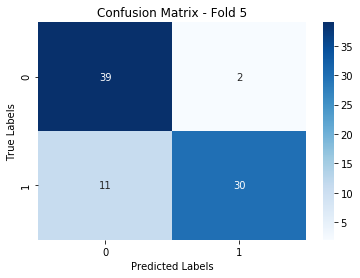

<Figure size 432x288 with 0 Axes>

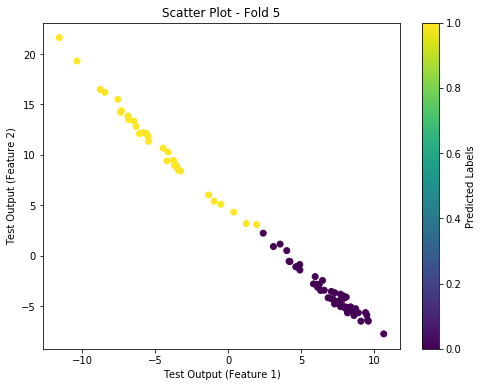

++++Use resnet_18 model+++
starting!!!-----------------------------------------------
Accuracy: 0.8414634146341463
Sensitivity: 0.7317073170731707
Specificity: 0.9512195121951219
Precision: 0.9375
Ending!!!------------------------------------------------------
(0.7317073170731707, 0.9512195121951219)
Loss: Contrastive_loss class_name Dag Accuracy: 0.8414634146341463
              precision    recall  f1-score   support

           0       0.78      0.95      0.86        41
           1       0.94      0.73      0.82        41

    accuracy                           0.84        82
   macro avg       0.86      0.84      0.84        82
weighted avg       0.86      0.84      0.84        82

ARI: 0.4600441435482792
acc: 0.8414634146341463 precision: 0.9375 recall: 0.7317073170731707 fscore: 0.821917808219178 sensitivity: 0.7317073170731707 specificity: 0.9512195121951219 nmi 0.41207811272000766 ari 0.4600441435482792


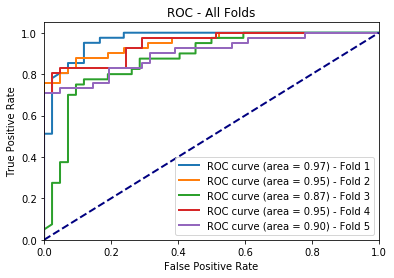

Average AUC: 0.93
Standard Deviation of AUC: 0.03


In [76]:
import json


def train_eval(datadir,skin_type, loss_select, model_select , dataset_choice ,category, epoch, n_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    torch.cuda.is_available()
    
    class_name = 'Dag'
    if model_select == 'resnet_18':
        model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # resnet = models.resnet18(pretrained=True)
    elif model_select == 'resnet_34':
         model_net = models.resnet34(pretrained=True)
    elif model_select == 'resnet_50':
        model_net = models.resnet50(pretrained=True)
    elif model_select == 'densenet':
         model_net = models.densenet121(pretrained=True)
        
    #resnet = models.alexnet(pretrained=True)
    
    model_net = model_net.to(device)
    # 将最后一层的输出维度修改为类别数目
    num_classes = 1024
    
    num_features = model_net.fc.in_features #512 # Resnet
#     num_features = model_net.classifier.in_features # Desnet101
    # import pdb;pdb.set_trace()
    model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
    model_net.fc = model_net.fc.to(device) #512 # Resnet
#     model_net.classifier = nn.Linear(num_features, num_classes) #desnet
    
    image_data_train_list, feature_data_train_list, adj_train_img_list, \
    adj_f_knn_train_list, image_data_test_list, test_feature_data_list, \
    adj_test_img_list, adj_f_knn_test_list, y_train_list ,y_test_list = dataloader_cv(datadir,skin_type, num_folds=5)
 
#     image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)
    
    
    all_aucs = []
    all_fpr = []
    all_tpr = []
    all_roc_auc = []
    false_positives = []  # 用于存储 False Positives 的样本 ID
    false_negatives = []  # 用于存储 False Negatives 的样本 ID

    for fold in range(len(image_data_train_list)):
        print(f"Fold {fold + 1}/{len(image_data_train_list)}:")
        
        image_data_train = image_data_train_list[fold]
        feature_data_train = feature_data_train_list[fold]
        adj_train_img = adj_train_img_list[fold]
        adj_f_knn_train = adj_f_knn_train_list[fold]
        image_data_test = image_data_test_list[fold]
        test_feature_data = test_feature_data_list[fold]
        adj_test_img = adj_test_img_list[fold]
        adj_f_knn_test = adj_f_knn_test_list[fold]
        
        y_train = y_train_list[fold]
        y_test = y_test_list[fold]
     
        image_data_train = image_data_train.to(torch.float32).to(device)
        feature_data_train = feature_data_train.to(torch.float32).to(device)
        # import pdb;pdb.set_trace()
        adj_train_img = adj_train_img.to(torch.float32).to(device)
        adj_f_knn_train = adj_f_knn_train.to(torch.float32).to(device)
        image_data_test = image_data_test.to(torch.float32).to(device)
        test_feature_data = test_feature_data.to(torch.float32).to(device)
        adj_test_img = adj_test_img.to(torch.float32).to(device)
        adj_f_knn_test = adj_f_knn_test.to(torch.float32).to(device)

        # y_train = y_train.to(device)
        # y_test = y_test.to(device)
        
        # import pdb;pdb.set_trace()


        projection = Projection(262, 3)
        if datadir == 'skin':
            model = Model_SKIN(projection, model_net, n_classes).to(device)
        elif datadir == 'abide':
            model = Model_ABIDE(projection, model_net, n_classes).to(device)
        elif datadir == 'pd':
            model = Model_PD(projection, model_net, n_classes).to(device, dtype=torch.float32)

        class_weights = torch.full((1,n_classes),0.5).view(-1)
        criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

        if loss_select == 'Contrastive_loss':
             criterion2 = contrastive_loss

        elif loss_select == 'MGEC_loss':
            criterion2 = MGECLoss()

        elif loss_select == 'InfoNCE_loss':
            criterion2 = info_loss

        elif loss_select == 'SAC_loss':
            criterion2 = SACLoss()

    # criterion3 = loss_dependence
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        n_epochs = epoch

        training_range = tqdm(range(n_epochs))

        for epoch in training_range:
            optimizer.zero_grad()
            # cnn_z  =  cnn_encoder(image_data)
            # 前向传播

            # image_data_train = image_data_train.to(device)
            # feature_data_train = feature_data_train.to(device)
            # adj_train_img = adj_train_img.to(device)
            # adj_f_knn_train = adj_f_knn_train.to(device)
            
            output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train)
      
            
            y = torch.from_numpy(y_train).to(torch.int64).to(device)

            loss_ce1 = criterion1(output1, y)
            loss_ce2 = criterion1(output2, y)
            alpha = 0.4

            if loss_select == 'Contrastive_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
                loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra

            elif loss_select == 'MGEC_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(output1, output2, adj, diag )
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
                #loss = loss_extra

            elif loss_select == 'InfoNCE_loss':
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

            elif loss_select == 'SAC_loss':    
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(emb, adj)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
            elif loss_select == 'only_CE':
                loss = loss_ce1 + loss_ce2


            loss.backward()
            optimizer.step()
            # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

        model.eval()
        with torch.no_grad():
            # import pdb;pdb.set_trace()
#             image_data_test = image_data_test.to(device)
#             test_feature_data = test_feature_data.to(device)
#             adj_test_img = adj_test_img.to(device)
#             adj_f_knn_test = adj_f_knn_test.to(device)
            # import pdb;pdb.set_trace()
            test_output1, test_output2, emb  = model(image_data_test, test_feature_data , adj_test_img, adj_f_knn_test )

            # test_output1  = model(test_image_data, test_adjacency_matrix, adj_test_img )
            m = nn.Softmax(dim=1)
            # import pdb;pdb.set_trace()
            test_output = test_output1 + test_output2
        #     test_output = emb

            #z = test_output1 + test_output2

            #num_clusters = 3
            #kmeans = KMeans(n_clusters=num_clusters)

            #cluster_labels = kmeans.fit_predict(z.cpu().data.numpy())
            #cluster_labels = torch.tensor(cluster_labels,dtype=torch.int64).to(device)



            pred =  m(test_output).argmax(dim=1)
            pred_prob = m(test_output)[:,1]
            #pred = cluster_labels
            # test_output = test_output.argmax(dim=1)


            # y_test = torch.empty(100).random_(2)
        #     y_test = torch.tensor(label_3_test).to(device)
#             y_test = torch.from_numpy(label_return(dataset_choice ,class_name, "test")).to(device)

            # import pdb;pdb.set_trace()
            y_test = torch.from_numpy(y_test).to(torch.int64).to(device)
            correct = (pred  == y_test).sum().item()
            accuracy = correct / len(y_test)
#             import pdb;pdb.set_trace()
            fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), pred_prob.cpu().detach().numpy())
            roc_auc = auc(fpr, tpr)
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_roc_auc.append(roc_auc)
            all_aucs.append(roc_auc)
            
            false_positive_indices = np.where((y_test == 0) & (pred.cpu().detach().numpy() == 1))[0]
            false_negative_indices = np.where((y_test == 1) & (pred.cpu().detach().numpy() == 0))[0]

            false_positives.append(false_positive_indices.tolist())
            false_negatives.append(false_negative_indices.tolist())
            
            cm = confusion_matrix(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
            plt.figure()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - Fold {fold + 1}')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            
            plt.figure()

            plt.figure(figsize=(8, 6))
            plt.scatter(test_output[:, 0].cpu().detach().numpy(), test_output[:, 1].cpu().detach().numpy(), c=pred.cpu().detach().numpy())
            plt.colorbar(label='Predicted Labels')
            plt.xlabel('Test Output (Feature 1)')
            plt.ylabel('Test Output (Feature 2)')
            plt.title(f'Scatter Plot - Fold {fold + 1}')
            plt.show()



#             import pdb;pdb.set_trace()
            print(f"++++Use {model_select} model+++")
            print(calculate_metrics_new(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            print("Loss:", loss_select, "class_name",class_name,"Accuracy:", accuracy)
            print(classification_report(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            if datadir == 'pd':
                accuracy, precision, recall, fscore, sensivity, specificity, nmi, ari = run_eval(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
                print("acc:",accuracy, "precision:", precision,"recall:", recall,"fscore:", fscore,"sensitivity:", sensivity,"specificity:", specificity, "nmi", nmi, "ari", ari)
                # plot_ROC(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, classes, skin_type, loss_select)
                # print_auc(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, category, skin_type, loss_select)


    plt.figure()
    for i in range(5):
        plt.plot(all_fpr[i], all_tpr[i], lw=2, label=f'ROC curve (area = {all_roc_auc[i]:.2f}) - Fold {i + 1}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - All Folds')
    plt.legend(loc="lower right")
    plt.show()   
    
    # 计算 AUC 的平均值和标准差
    avg_auc = np.mean(all_aucs)
    std_auc = np.std(all_aucs)

    print(f'Average AUC: {avg_auc:.2f}')
    print(f'Standard Deviation of AUC: {std_auc:.2f}')

    # 存储 False Positives 和 False Negatives 到 JSON 文件
#     result_data = {
#         'FalsePositives': false_positives,
#         'FalseNegatives': false_negatives
#     }

#     with open('false_samples.json', 'w') as json_file:
#         json.dump(result_data, json_file, indent=4)

            
def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_data_dir', type=str, default='pd')
#     parser.add_argument('--skin_type', type=str, default='dermatology_images')
#     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
#     parser.add_argument('--model_select', type=str, default='densenet')
#     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
#     parser.add_argument('--dataset_choice', type=str, default='pd')
#     parser.add_argument('--category', type=str)
#     parser.add_argument('--n_epoch', type=int, default=300)
#     parser.add_argument('--n_classes', type=int, default=2)
    
#     args = parser.parse_args()

    img_data_dir = 'pd'
    skin_type = 'dermatology_images'
    losses_choice = 'Contrastive_loss'
    model_select = 'resnet_18'
    dataset_choice = 'pd'
    category = 'your_category'  # 设置正确的类别值
    n_epoch = 300
    n_classes = 2

    train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)
#     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


if __name__ == '__main__':
    main()


/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)











  0%|          | 0/300 [00:00<?, ?it/s]

Fold 1/5:













  0%|          | 1/300 [00:00<01:56,  2.57it/s]










  1%|          | 2/300 [00:00<01:56,  2.57it/s]










  1%|          | 3/300 [00:01<01:58,  2.51it/s]










  1%|▏         | 4/300 [00:01<01:57,  2.51it/s]










  2%|▏         | 5/300 [00:02<01:58,  2.48it/s]










  2%|▏         | 6/300 [00:02<02:00,  2.43it/s]










  2%|▏         | 7/300 [00:02<01:59,  2.46it/s]










  3%|▎         | 8/300 [00:03<01:58,  2.47it/s]










  3%|▎         | 9/300 [00:03<01:57,  2.48it/s]










  3%|▎         | 10/300 [00:04<01:56,  2.48it/s]










  4%|▎         | 11/300 [00:04<01:56,  2.48it/s]










  4%|▍         | 12/300 [00:04<01:56,  2.48it/s]










  4%|▍         | 13/300 [00:05<01:55,  2.47it/s]










  5%|▍         | 14/300 [00:05<01:55,  2.48it/s]










  5%|▌         | 15/300 [00:06<01:54,  2.49it/s]










  5%|▌         | 16/300 [00:06<01:56,  2.44it/s]










  6%|▌         | 17/300 [00:06<01:55,  2.45it/s]







 30%|███       | 90/300 [00:37<01:27,  2.39it/s]










 30%|███       | 91/300 [00:37<01:26,  2.41it/s]










 31%|███       | 92/300 [00:37<01:26,  2.42it/s]










 31%|███       | 93/300 [00:38<01:25,  2.41it/s]










 31%|███▏      | 94/300 [00:38<01:26,  2.37it/s]










 32%|███▏      | 95/300 [00:39<01:25,  2.39it/s]










 32%|███▏      | 96/300 [00:39<01:24,  2.40it/s]










 32%|███▏      | 97/300 [00:40<01:24,  2.39it/s]










 33%|███▎      | 98/300 [00:40<01:24,  2.40it/s]










 33%|███▎      | 99/300 [00:40<01:23,  2.40it/s]










 33%|███▎      | 100/300 [00:41<01:25,  2.35it/s]










 34%|███▎      | 101/300 [00:41<01:24,  2.36it/s]










 34%|███▍      | 102/300 [00:42<01:22,  2.39it/s]










 34%|███▍      | 103/300 [00:42<01:23,  2.36it/s]










 35%|███▍      | 104/300 [00:42<01:22,  2.38it/s]










 35%|███▌      | 105/300 [00:43<01:23,  2.35it/s]










 35%|███▌      | 106/300 [00:43<01:21,  2.37it/s]


 59%|█████▉    | 178/300 [01:14<00:51,  2.38it/s]










 60%|█████▉    | 179/300 [01:14<00:51,  2.37it/s]










 60%|██████    | 180/300 [01:15<00:50,  2.37it/s]










 60%|██████    | 181/300 [01:15<00:50,  2.36it/s]










 61%|██████    | 182/300 [01:16<00:49,  2.37it/s]










 61%|██████    | 183/300 [01:16<00:50,  2.33it/s]










 61%|██████▏   | 184/300 [01:16<00:49,  2.33it/s]










 62%|██████▏   | 185/300 [01:17<00:49,  2.33it/s]










 62%|██████▏   | 186/300 [01:17<00:48,  2.33it/s]










 62%|██████▏   | 187/300 [01:18<00:48,  2.32it/s]










 63%|██████▎   | 188/300 [01:18<00:48,  2.33it/s]










 63%|██████▎   | 189/300 [01:19<00:47,  2.33it/s]










 63%|██████▎   | 190/300 [01:19<00:47,  2.31it/s]










 64%|██████▎   | 191/300 [01:19<00:46,  2.32it/s]










 64%|██████▍   | 192/300 [01:20<00:46,  2.33it/s]










 64%|██████▍   | 193/300 [01:20<00:45,  2.34it/s]










 65%|██████▍   | 194/300 [01:21<00:45,  

 89%|████████▊ | 266/300 [01:53<00:15,  2.17it/s]










 89%|████████▉ | 267/300 [01:54<00:15,  2.17it/s]










 89%|████████▉ | 268/300 [01:54<00:14,  2.18it/s]










 90%|████████▉ | 269/300 [01:55<00:14,  2.18it/s]










 90%|█████████ | 270/300 [01:55<00:13,  2.19it/s]










 90%|█████████ | 271/300 [01:55<00:13,  2.19it/s]










 91%|█████████ | 272/300 [01:56<00:12,  2.16it/s]










 91%|█████████ | 273/300 [01:56<00:12,  2.16it/s]










 91%|█████████▏| 274/300 [01:57<00:11,  2.18it/s]










 92%|█████████▏| 275/300 [01:57<00:11,  2.19it/s]










 92%|█████████▏| 276/300 [01:58<00:11,  2.18it/s]










 92%|█████████▏| 277/300 [01:58<00:10,  2.19it/s]










 93%|█████████▎| 278/300 [01:59<00:09,  2.21it/s]










 93%|█████████▎| 279/300 [01:59<00:09,  2.21it/s]










 93%|█████████▎| 280/300 [02:00<00:09,  2.22it/s]










 94%|█████████▎| 281/300 [02:00<00:08,  2.23it/s]










 94%|█████████▍| 282/300 [02:00<00:08,  

++++Use densenet model+++
starting!!!-----------------------------------------------
Accuracy: 0.9036144578313253
Sensitivity: 0.9024390243902439
Specificity: 0.9047619047619048
Precision: 0.9024390243902439
Ending!!!------------------------------------------------------
(0.9024390243902439, 0.9047619047619048)
Loss: Contrastive_loss class_name Dag Accuracy: 0.9036144578313253
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1       0.90      0.90      0.90        41

    accuracy                           0.90        83
   macro avg       0.90      0.90      0.90        83
weighted avg       0.90      0.90      0.90        83

ARI: 0.6473187728392963
acc: 0.9036144578313253 precision: 0.9024390243902439 recall: 0.9024390243902439 fscore: 0.9024390243902439 sensitivity: 0.9024390243902439 specificity: 0.9047619047619048 nmi 0.5425310863223767 ari 0.6473187728392963
Fold 2/5:













  0%|          | 1/299 [00:00<02:08,  2.32it/s]










  1%|          | 2/299 [00:00<02:08,  2.31it/s]










  1%|          | 3/299 [00:01<02:09,  2.29it/s]










  1%|▏         | 4/299 [00:01<02:09,  2.28it/s]










  2%|▏         | 5/299 [00:02<02:08,  2.29it/s]










  2%|▏         | 6/299 [00:02<02:08,  2.28it/s]










  2%|▏         | 7/299 [00:03<02:07,  2.28it/s]










  3%|▎         | 8/299 [00:03<02:07,  2.28it/s]










  3%|▎         | 9/299 [00:03<02:07,  2.28it/s]










  3%|▎         | 10/299 [00:04<02:06,  2.28it/s]










  4%|▎         | 11/299 [00:04<02:06,  2.27it/s]










  4%|▍         | 12/299 [00:05<02:09,  2.22it/s]










  4%|▍         | 13/299 [00:05<02:08,  2.22it/s]










  5%|▍         | 14/299 [00:06<02:07,  2.23it/s]










  5%|▌         | 15/299 [00:06<02:09,  2.19it/s]










  5%|▌         | 16/299 [00:07<02:08,  2.20it/s]










  6%|▌         | 17/299 [00:07<02:08,  2.20it/s]







 30%|███       | 90/299 [00:40<01:34,  2.21it/s]










 30%|███       | 91/299 [00:41<01:33,  2.22it/s]










 31%|███       | 92/299 [00:41<01:33,  2.21it/s]










 31%|███       | 93/299 [00:42<01:35,  2.15it/s]










 31%|███▏      | 94/299 [00:42<01:34,  2.18it/s]










 32%|███▏      | 95/299 [00:43<01:33,  2.19it/s]










 32%|███▏      | 96/299 [00:43<01:32,  2.20it/s]










 32%|███▏      | 97/299 [00:44<01:31,  2.20it/s]










 33%|███▎      | 98/299 [00:44<01:30,  2.21it/s]










 33%|███▎      | 99/299 [00:45<01:30,  2.22it/s]










 33%|███▎      | 100/299 [00:45<01:29,  2.22it/s]










 34%|███▍      | 101/299 [00:45<01:29,  2.22it/s]










 34%|███▍      | 102/299 [00:46<01:29,  2.19it/s]










 34%|███▍      | 103/299 [00:46<01:28,  2.20it/s]










 35%|███▍      | 104/299 [00:47<01:28,  2.20it/s]










 35%|███▌      | 105/299 [00:47<01:27,  2.21it/s]










 35%|███▌      | 106/299 [00:48<01:27,  2.22it/s]


 60%|█████▉    | 178/299 [01:20<00:55,  2.18it/s]










 60%|█████▉    | 179/299 [01:21<00:54,  2.19it/s]










 60%|██████    | 180/299 [01:21<00:54,  2.18it/s]










 61%|██████    | 181/299 [01:22<00:54,  2.18it/s]










 61%|██████    | 182/299 [01:22<00:53,  2.18it/s]










 61%|██████    | 183/299 [01:23<00:53,  2.18it/s]










 62%|██████▏   | 184/299 [01:23<00:52,  2.18it/s]










 62%|██████▏   | 185/299 [01:24<00:52,  2.19it/s]










 62%|██████▏   | 186/299 [01:24<00:51,  2.18it/s]










 63%|██████▎   | 187/299 [01:25<00:52,  2.13it/s]










 63%|██████▎   | 188/299 [01:25<00:51,  2.16it/s]










 63%|██████▎   | 189/299 [01:25<00:50,  2.17it/s]










 64%|██████▎   | 190/299 [01:26<00:50,  2.18it/s]










 64%|██████▍   | 191/299 [01:26<00:49,  2.19it/s]










 64%|██████▍   | 192/299 [01:27<00:48,  2.19it/s]










 65%|██████▍   | 193/299 [01:27<00:48,  2.18it/s]










 65%|██████▍   | 194/299 [01:28<00:48,  

 89%|████████▉ | 266/299 [02:00<00:15,  2.17it/s]










 89%|████████▉ | 267/299 [02:01<00:14,  2.19it/s]










 90%|████████▉ | 268/299 [02:01<00:14,  2.17it/s]










 90%|████████▉ | 269/299 [02:02<00:13,  2.17it/s]










 90%|█████████ | 270/299 [02:02<00:13,  2.17it/s]










 91%|█████████ | 271/299 [02:03<00:12,  2.17it/s]










 91%|█████████ | 272/299 [02:03<00:12,  2.17it/s]










 91%|█████████▏| 273/299 [02:04<00:12,  2.14it/s]










 92%|█████████▏| 274/299 [02:04<00:11,  2.15it/s]










 92%|█████████▏| 275/299 [02:05<00:11,  2.16it/s]










 92%|█████████▏| 276/299 [02:05<00:10,  2.17it/s]










 93%|█████████▎| 277/299 [02:06<00:10,  2.14it/s]










 93%|█████████▎| 278/299 [02:06<00:09,  2.15it/s]










 93%|█████████▎| 279/299 [02:06<00:09,  2.16it/s]










 94%|█████████▎| 280/299 [02:07<00:08,  2.17it/s]










 94%|█████████▍| 281/299 [02:07<00:08,  2.18it/s]










 94%|█████████▍| 282/299 [02:08<00:07,  

++++Use densenet model+++
starting!!!-----------------------------------------------
Accuracy: 0.8554216867469879
Sensitivity: 0.8536585365853658
Specificity: 0.8571428571428571
Precision: 0.8536585365853658
Ending!!!------------------------------------------------------
(0.8536585365853658, 0.8571428571428571)
Loss: Contrastive_loss class_name Dag Accuracy: 0.8554216867469879
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        42
           1       0.85      0.85      0.85        41

    accuracy                           0.86        83
   macro avg       0.86      0.86      0.86        83
weighted avg       0.86      0.86      0.86        83

ARI: 0.4991926574318008
acc: 0.8554216867469879 precision: 0.8536585365853658 recall: 0.8536585365853658 fscore: 0.8536585365853658 sensitivity: 0.8536585365853658 specificity: 0.8571428571428571 nmi 0.40385072877455536 ari 0.4991926574318008
Fold 3/5:













  0%|          | 1/298 [00:00<02:22,  2.08it/s]










  1%|          | 2/298 [00:00<02:19,  2.12it/s]










  1%|          | 3/298 [00:01<02:20,  2.10it/s]










  1%|▏         | 4/298 [00:01<02:17,  2.13it/s]










  2%|▏         | 5/298 [00:02<02:15,  2.16it/s]










  2%|▏         | 6/298 [00:02<02:14,  2.18it/s]










  2%|▏         | 7/298 [00:03<02:13,  2.19it/s]










  3%|▎         | 8/298 [00:03<02:12,  2.18it/s]










  3%|▎         | 9/298 [00:04<02:11,  2.20it/s]










  3%|▎         | 10/298 [00:04<02:10,  2.21it/s]










  4%|▎         | 11/298 [00:05<02:09,  2.21it/s]










  4%|▍         | 12/298 [00:05<02:09,  2.21it/s]










  4%|▍         | 13/298 [00:05<02:08,  2.22it/s]










  5%|▍         | 14/298 [00:06<02:07,  2.22it/s]










  5%|▌         | 15/298 [00:06<02:11,  2.15it/s]










  5%|▌         | 16/298 [00:07<02:09,  2.17it/s]










  6%|▌         | 17/298 [00:07<02:08,  2.18it/s]







 30%|███       | 90/298 [00:41<01:35,  2.18it/s]










 31%|███       | 91/298 [00:41<01:34,  2.19it/s]










 31%|███       | 92/298 [00:42<01:33,  2.20it/s]










 31%|███       | 93/298 [00:42<01:33,  2.20it/s]










 32%|███▏      | 94/298 [00:43<01:32,  2.20it/s]










 32%|███▏      | 95/298 [00:43<01:32,  2.20it/s]










 32%|███▏      | 96/298 [00:43<01:33,  2.16it/s]










 33%|███▎      | 97/298 [00:44<01:32,  2.17it/s]










 33%|███▎      | 98/298 [00:44<01:33,  2.14it/s]










 33%|███▎      | 99/298 [00:45<01:32,  2.15it/s]










 34%|███▎      | 100/298 [00:45<01:31,  2.16it/s]










 34%|███▍      | 101/298 [00:46<01:33,  2.11it/s]










 34%|███▍      | 102/298 [00:46<01:31,  2.14it/s]










 35%|███▍      | 103/298 [00:47<01:30,  2.16it/s]










 35%|███▍      | 104/298 [00:47<01:28,  2.18it/s]










 35%|███▌      | 105/298 [00:48<01:27,  2.20it/s]










 36%|███▌      | 106/298 [00:48<01:27,  2.20it/s]


 60%|█████▉    | 178/298 [01:21<00:54,  2.19it/s]










 60%|██████    | 179/298 [01:21<00:55,  2.16it/s]










 60%|██████    | 180/298 [01:22<00:54,  2.17it/s]










 61%|██████    | 181/298 [01:22<00:54,  2.15it/s]










 61%|██████    | 182/298 [01:23<00:53,  2.16it/s]










 61%|██████▏   | 183/298 [01:23<00:52,  2.18it/s]










 62%|██████▏   | 184/298 [01:24<00:52,  2.19it/s]










 62%|██████▏   | 185/298 [01:24<00:51,  2.20it/s]










 62%|██████▏   | 186/298 [01:24<00:50,  2.20it/s]










 63%|██████▎   | 187/298 [01:25<00:50,  2.20it/s]










 63%|██████▎   | 188/298 [01:25<00:49,  2.21it/s]










 63%|██████▎   | 189/298 [01:26<00:49,  2.20it/s]










 64%|██████▍   | 190/298 [01:26<00:49,  2.17it/s]










 64%|██████▍   | 191/298 [01:27<00:49,  2.18it/s]










 64%|██████▍   | 192/298 [01:27<00:48,  2.19it/s]










 65%|██████▍   | 193/298 [01:28<00:47,  2.19it/s]










 65%|██████▌   | 194/298 [01:28<00:47,  

 89%|████████▉ | 266/298 [02:01<00:14,  2.16it/s]










 90%|████████▉ | 267/298 [02:02<00:14,  2.17it/s]










 90%|████████▉ | 268/298 [02:02<00:13,  2.18it/s]










 90%|█████████ | 269/298 [02:03<00:13,  2.17it/s]










 91%|█████████ | 270/298 [02:03<00:12,  2.17it/s]










 91%|█████████ | 271/298 [02:04<00:12,  2.17it/s]










 91%|█████████▏| 272/298 [02:04<00:11,  2.18it/s]










 92%|█████████▏| 273/298 [02:04<00:11,  2.19it/s]










 92%|█████████▏| 274/298 [02:05<00:10,  2.20it/s]










 92%|█████████▏| 275/298 [02:05<00:10,  2.20it/s]










 93%|█████████▎| 276/298 [02:06<00:10,  2.19it/s]










 93%|█████████▎| 277/298 [02:06<00:09,  2.20it/s]










 93%|█████████▎| 278/298 [02:07<00:09,  2.21it/s]










 94%|█████████▎| 279/298 [02:07<00:08,  2.20it/s]










 94%|█████████▍| 280/298 [02:08<00:08,  2.20it/s]










 94%|█████████▍| 281/298 [02:08<00:07,  2.21it/s]










 95%|█████████▍| 282/298 [02:09<00:07,  

++++Use densenet model+++
starting!!!-----------------------------------------------
Accuracy: 0.7804878048780488
Sensitivity: 0.75
Specificity: 0.8095238095238095
Precision: 0.7894736842105263
Ending!!!------------------------------------------------------
(0.75, 0.8095238095238095)
Loss: Contrastive_loss class_name Dag Accuracy: 0.7804878048780488
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        42
           1       0.79      0.75      0.77        40

    accuracy                           0.78        82
   macro avg       0.78      0.78      0.78        82
weighted avg       0.78      0.78      0.78        82

ARI: 0.30617663316692273
acc: 0.7804878048780488 precision: 0.7894736842105263 recall: 0.75 fscore: 0.7692307692307693 sensitivity: 0.75 specificity: 0.8095238095238095 nmi 0.241106854086961 ari 0.30617663316692273
Fold 4/5:













  0%|          | 1/297 [00:00<02:14,  2.21it/s]










  1%|          | 2/297 [00:00<02:13,  2.21it/s]










  1%|          | 3/297 [00:01<02:12,  2.21it/s]










  1%|▏         | 4/297 [00:01<02:11,  2.22it/s]










  2%|▏         | 5/297 [00:02<02:11,  2.23it/s]










  2%|▏         | 6/297 [00:02<02:11,  2.22it/s]










  2%|▏         | 7/297 [00:03<02:10,  2.22it/s]










  3%|▎         | 8/297 [00:03<02:10,  2.22it/s]










  3%|▎         | 9/297 [00:04<02:09,  2.22it/s]










  3%|▎         | 10/297 [00:04<02:09,  2.22it/s]










  4%|▎         | 11/297 [00:04<02:08,  2.23it/s]










  4%|▍         | 12/297 [00:05<02:07,  2.23it/s]










  4%|▍         | 13/297 [00:05<02:07,  2.23it/s]










  5%|▍         | 14/297 [00:06<02:07,  2.23it/s]










  5%|▌         | 15/297 [00:06<02:08,  2.19it/s]










  5%|▌         | 16/297 [00:07<02:07,  2.20it/s]










  6%|▌         | 17/297 [00:07<02:06,  2.21it/s]







 30%|███       | 90/297 [00:40<01:33,  2.21it/s]










 31%|███       | 91/297 [00:41<01:33,  2.20it/s]










 31%|███       | 92/297 [00:41<01:33,  2.19it/s]










 31%|███▏      | 93/297 [00:42<01:34,  2.15it/s]










 32%|███▏      | 94/297 [00:42<01:34,  2.16it/s]










 32%|███▏      | 95/297 [00:42<01:34,  2.13it/s]










 32%|███▏      | 96/297 [00:43<01:33,  2.14it/s]










 33%|███▎      | 97/297 [00:43<01:32,  2.15it/s]










 33%|███▎      | 98/297 [00:44<01:31,  2.17it/s]










 33%|███▎      | 99/297 [00:44<01:31,  2.17it/s]










 34%|███▎      | 100/297 [00:45<01:30,  2.18it/s]










 34%|███▍      | 101/297 [00:45<01:30,  2.17it/s]










 34%|███▍      | 102/297 [00:46<01:30,  2.16it/s]










 35%|███▍      | 103/297 [00:46<01:29,  2.16it/s]










 35%|███▌      | 104/297 [00:47<01:29,  2.16it/s]










 35%|███▌      | 105/297 [00:47<01:28,  2.16it/s]










 36%|███▌      | 106/297 [00:48<01:28,  2.16it/s]


 60%|█████▉    | 178/297 [01:21<00:55,  2.16it/s]










 60%|██████    | 179/297 [01:21<00:54,  2.17it/s]










 61%|██████    | 180/297 [01:21<00:53,  2.17it/s]










 61%|██████    | 181/297 [01:22<00:53,  2.17it/s]










 61%|██████▏   | 182/297 [01:22<00:53,  2.17it/s]










 62%|██████▏   | 183/297 [01:23<00:52,  2.17it/s]










 62%|██████▏   | 184/297 [01:23<00:51,  2.18it/s]










 62%|██████▏   | 185/297 [01:24<00:51,  2.18it/s]










 63%|██████▎   | 186/297 [01:24<00:50,  2.19it/s]










 63%|██████▎   | 187/297 [01:25<00:50,  2.19it/s]










 63%|██████▎   | 188/297 [01:25<00:49,  2.20it/s]










 64%|██████▎   | 189/297 [01:26<00:49,  2.19it/s]










 64%|██████▍   | 190/297 [01:26<00:48,  2.19it/s]










 64%|██████▍   | 191/297 [01:26<00:48,  2.19it/s]










 65%|██████▍   | 192/297 [01:27<00:48,  2.15it/s]










 65%|██████▍   | 193/297 [01:27<00:48,  2.16it/s]










 65%|██████▌   | 194/297 [01:28<00:47,  

 90%|████████▉ | 266/297 [02:01<00:14,  2.15it/s]










 90%|████████▉ | 267/297 [02:02<00:13,  2.16it/s]










 90%|█████████ | 268/297 [02:02<00:13,  2.17it/s]










 91%|█████████ | 269/297 [02:02<00:12,  2.18it/s]










 91%|█████████ | 270/297 [02:03<00:12,  2.18it/s]










 91%|█████████ | 271/297 [02:03<00:11,  2.19it/s]










 92%|█████████▏| 272/297 [02:04<00:11,  2.19it/s]










 92%|█████████▏| 273/297 [02:04<00:11,  2.17it/s]










 92%|█████████▏| 274/297 [02:05<00:10,  2.18it/s]










 93%|█████████▎| 275/297 [02:05<00:10,  2.18it/s]










 93%|█████████▎| 276/297 [02:06<00:09,  2.18it/s]










 93%|█████████▎| 277/297 [02:06<00:09,  2.19it/s]










 94%|█████████▎| 278/297 [02:07<00:08,  2.19it/s]










 94%|█████████▍| 279/297 [02:07<00:08,  2.19it/s]










 94%|█████████▍| 280/297 [02:08<00:07,  2.15it/s]










 95%|█████████▍| 281/297 [02:08<00:07,  2.15it/s]










 95%|█████████▍| 282/297 [02:08<00:06,  

++++Use densenet model+++
starting!!!-----------------------------------------------
Accuracy: 0.8536585365853658
Sensitivity: 0.8292682926829268
Specificity: 0.8780487804878049
Precision: 0.8717948717948718
Ending!!!------------------------------------------------------
(0.8292682926829268, 0.8780487804878049)
Loss: Contrastive_loss class_name Dag Accuracy: 0.8536585365853658
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        41
           1       0.87      0.83      0.85        41

    accuracy                           0.85        82
   macro avg       0.85      0.85      0.85        82
weighted avg       0.85      0.85      0.85        82

ARI: 0.49406620861961276
acc: 0.8536585365853658 precision: 0.8717948717948718 recall: 0.8292682926829268 fscore: 0.85 sensitivity: 0.8292682926829268 specificity: 0.8780487804878049 nmi 0.40146774696976734 ari 0.49406620861961276
Fold 5/5:













  0%|          | 1/296 [00:00<02:13,  2.21it/s]










  1%|          | 2/296 [00:00<02:15,  2.16it/s]










  1%|          | 3/296 [00:01<02:15,  2.17it/s]










  1%|▏         | 4/296 [00:01<02:14,  2.18it/s]










  2%|▏         | 5/296 [00:02<02:13,  2.18it/s]










  2%|▏         | 6/296 [00:02<02:12,  2.18it/s]










  2%|▏         | 7/296 [00:03<02:15,  2.14it/s]










  3%|▎         | 8/296 [00:03<02:13,  2.15it/s]










  3%|▎         | 9/296 [00:04<02:12,  2.17it/s]










  3%|▎         | 10/296 [00:04<02:11,  2.17it/s]










  4%|▎         | 11/296 [00:05<02:10,  2.18it/s]










  4%|▍         | 12/296 [00:05<02:10,  2.18it/s]










  4%|▍         | 13/296 [00:05<02:09,  2.18it/s]










  5%|▍         | 14/296 [00:06<02:09,  2.18it/s]










  5%|▌         | 15/296 [00:06<02:09,  2.17it/s]










  5%|▌         | 16/296 [00:07<02:08,  2.17it/s]










  6%|▌         | 17/296 [00:07<02:08,  2.17it/s]







 30%|███       | 90/296 [00:41<01:36,  2.13it/s]










 31%|███       | 91/296 [00:42<01:37,  2.10it/s]










 31%|███       | 92/296 [00:42<01:37,  2.09it/s]










 31%|███▏      | 93/296 [00:43<01:36,  2.10it/s]










 32%|███▏      | 94/296 [00:43<01:35,  2.11it/s]










 32%|███▏      | 95/296 [00:44<01:34,  2.12it/s]










 32%|███▏      | 96/296 [00:44<01:34,  2.13it/s]










 33%|███▎      | 97/296 [00:45<01:33,  2.13it/s]










 33%|███▎      | 98/296 [00:45<01:32,  2.14it/s]










 33%|███▎      | 99/296 [00:46<01:33,  2.11it/s]










 34%|███▍      | 100/296 [00:46<01:32,  2.12it/s]










 34%|███▍      | 101/296 [00:47<01:30,  2.14it/s]










 34%|███▍      | 102/296 [00:47<01:30,  2.15it/s]










 35%|███▍      | 103/296 [00:47<01:29,  2.16it/s]










 35%|███▌      | 104/296 [00:48<01:28,  2.17it/s]










 35%|███▌      | 105/296 [00:48<01:27,  2.17it/s]










 36%|███▌      | 106/296 [00:49<01:27,  2.17it/s]


 60%|██████    | 178/296 [01:22<00:54,  2.15it/s]










 60%|██████    | 179/296 [01:22<00:53,  2.17it/s]










 61%|██████    | 180/296 [01:23<00:53,  2.17it/s]










 61%|██████    | 181/296 [01:23<00:52,  2.18it/s]










 61%|██████▏   | 182/296 [01:24<00:52,  2.19it/s]










 62%|██████▏   | 183/296 [01:24<00:51,  2.19it/s]










 62%|██████▏   | 184/296 [01:25<00:51,  2.19it/s]










 62%|██████▎   | 185/296 [01:25<00:51,  2.16it/s]










 63%|██████▎   | 186/296 [01:26<00:51,  2.15it/s]










 63%|██████▎   | 187/296 [01:26<00:50,  2.16it/s]










 64%|██████▎   | 188/296 [01:27<00:49,  2.17it/s]










 64%|██████▍   | 189/296 [01:27<00:49,  2.18it/s]










 64%|██████▍   | 190/296 [01:27<00:48,  2.19it/s]










 65%|██████▍   | 191/296 [01:28<00:47,  2.19it/s]










 65%|██████▍   | 192/296 [01:28<00:47,  2.19it/s]










 65%|██████▌   | 193/296 [01:29<00:46,  2.20it/s]










 66%|██████▌   | 194/296 [01:29<00:46,  

 90%|████████▉ | 266/296 [02:02<00:13,  2.16it/s]










 90%|█████████ | 267/296 [02:03<00:13,  2.16it/s]










 91%|█████████ | 268/296 [02:03<00:13,  2.14it/s]










 91%|█████████ | 269/296 [02:04<00:12,  2.11it/s]










 91%|█████████ | 270/296 [02:04<00:12,  2.11it/s]










 92%|█████████▏| 271/296 [02:05<00:11,  2.13it/s]










 92%|█████████▏| 272/296 [02:05<00:11,  2.09it/s]










 92%|█████████▏| 273/296 [02:06<00:10,  2.11it/s]










 93%|█████████▎| 274/296 [02:06<00:10,  2.12it/s]










 93%|█████████▎| 275/296 [02:07<00:09,  2.13it/s]










 93%|█████████▎| 276/296 [02:07<00:09,  2.14it/s]










 94%|█████████▎| 277/296 [02:08<00:08,  2.14it/s]










 94%|█████████▍| 278/296 [02:08<00:08,  2.13it/s]










 94%|█████████▍| 279/296 [02:09<00:08,  2.10it/s]










 95%|█████████▍| 280/296 [02:09<00:07,  2.07it/s]










 95%|█████████▍| 281/296 [02:10<00:07,  2.07it/s]










 95%|█████████▌| 282/296 [02:10<00:06,  

++++Use densenet model+++
starting!!!-----------------------------------------------
Accuracy: 0.8780487804878049
Sensitivity: 0.7804878048780488
Specificity: 0.975609756097561
Precision: 0.9696969696969697
Ending!!!------------------------------------------------------
(0.7804878048780488, 0.975609756097561)
Loss: Contrastive_loss class_name Dag Accuracy: 0.8780487804878049
              precision    recall  f1-score   support

           0       0.82      0.98      0.89        41
           1       0.97      0.78      0.86        41

    accuracy                           0.88        82
   macro avg       0.89      0.88      0.88        82
weighted avg       0.89      0.88      0.88        82

ARI: 0.5665358544416697
acc: 0.8780487804878049 precision: 0.9696969696969697 recall: 0.7804878048780488 fscore: 0.8648648648648649 sensitivity: 0.7804878048780488 specificity: 0.975609756097561 nmi 0.5171552794398374 ari 0.5665358544416697


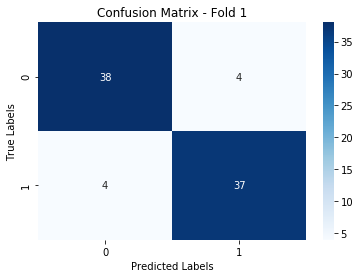

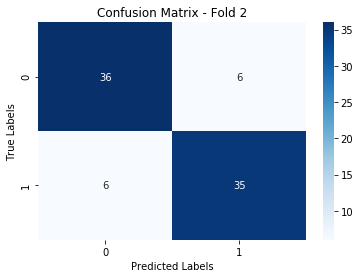

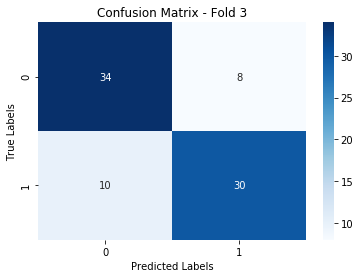

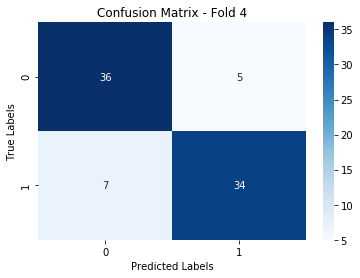

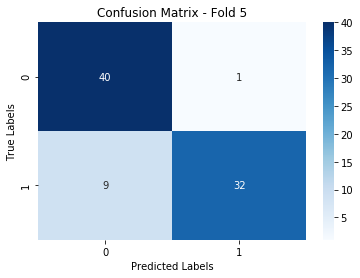

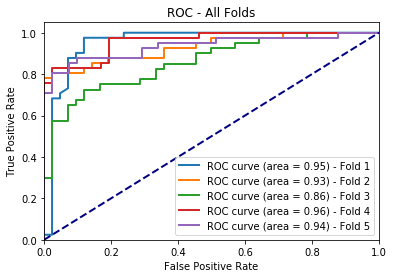

Average AUC: 0.93
Standard Deviation of AUC: 0.04


In [66]:
import json


def train_eval(datadir,skin_type, loss_select, model_select , dataset_choice ,category, epoch, n_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    torch.cuda.is_available()
    
    class_name = 'Dag'
    if model_select == 'resnet_18':
        model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # resnet = models.resnet18(pretrained=True)
    elif model_select == 'resnet_34':
         model_net = models.resnet34(pretrained=True)
    elif model_select == 'resnet_50':
        model_net = models.resnet50(pretrained=True)
    elif model_select == 'densenet':
         model_net = models.densenet121(pretrained=True)
        
    #resnet = models.alexnet(pretrained=True)
    
    model_net = model_net.to(device)
    # 将最后一层的输出维度修改为类别数目
    num_classes = 1024
    
    # num_features = model_net.fc.in_features #512 # Resnet
    num_features = model_net.classifier.in_features # Desnet101
    # import pdb;pdb.set_trace()
    # model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
    # model_net.fc = model_net.fc.to(device) #512 # Resnet
    model_net.classifier = nn.Linear(num_features, num_classes) #desnet
    
    image_data_train_list, feature_data_train_list, adj_train_img_list, \
    adj_f_knn_train_list, image_data_test_list, test_feature_data_list, \
    adj_test_img_list, adj_f_knn_test_list, y_train_list ,y_test_list = dataloader_cv(datadir,skin_type, num_folds=5)
 
#     image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)
    
    
    all_aucs = []
    all_fpr = []
    all_tpr = []
    all_roc_auc = []
    false_positives = []  # 用于存储 False Positives 的样本 ID
    false_negatives = []  # 用于存储 False Negatives 的样本 ID

    for fold in range(len(image_data_train_list)):
        print(f"Fold {fold + 1}/{len(image_data_train_list)}:")
        
        image_data_train = image_data_train_list[fold]
        feature_data_train = feature_data_train_list[fold]
        adj_train_img = adj_train_img_list[fold]
        adj_f_knn_train = adj_f_knn_train_list[fold]
        image_data_test = image_data_test_list[fold]
        test_feature_data = test_feature_data_list[fold]
        adj_test_img = adj_test_img_list[fold]
        adj_f_knn_test = adj_f_knn_test_list[fold]
        
        y_train = y_train_list[fold]
        y_test = y_test_list[fold]
     
        image_data_train = image_data_train.to(torch.float32).to(device)
        feature_data_train = feature_data_train.to(torch.float32).to(device)
        # import pdb;pdb.set_trace()
        adj_train_img = adj_train_img.to(torch.float32).to(device)
        adj_f_knn_train = adj_f_knn_train.to(torch.float32).to(device)
        image_data_test = image_data_test.to(torch.float32).to(device)
        test_feature_data = test_feature_data.to(torch.float32).to(device)
        adj_test_img = adj_test_img.to(torch.float32).to(device)
        adj_f_knn_test = adj_f_knn_test.to(torch.float32).to(device)

        # y_train = y_train.to(device)
        # y_test = y_test.to(device)
        
        # import pdb;pdb.set_trace()


        projection = Projection(262, 3)
        if datadir == 'skin':
            model = Model_SKIN(projection, model_net, n_classes).to(device)
        elif datadir == 'abide':
            model = Model_ABIDE(projection, model_net, n_classes).to(device)
        elif datadir == 'pd':
            model = Model_PD(projection, model_net, n_classes).to(device, dtype=torch.float32)

        class_weights = torch.full((1,n_classes),0.5).view(-1)
        criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

        if loss_select == 'Contrastive_loss':
             criterion2 = contrastive_loss

        elif loss_select == 'MGEC_loss':
            criterion2 = MGECLoss()

        elif loss_select == 'InfoNCE_loss':
            criterion2 = info_loss

        elif loss_select == 'SAC_loss':
            criterion2 = SACLoss()

    # criterion3 = loss_dependence
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        n_epochs = epoch

        training_range = tqdm(range(n_epochs))

        for epoch in training_range:
            optimizer.zero_grad()
            # cnn_z  =  cnn_encoder(image_data)
            # 前向传播

            # image_data_train = image_data_train.to(device)
            # feature_data_train = feature_data_train.to(device)
            # adj_train_img = adj_train_img.to(device)
            # adj_f_knn_train = adj_f_knn_train.to(device)
            
            output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train)
      
            
            y = torch.from_numpy(y_train).to(torch.int64).to(device)

            loss_ce1 = criterion1(output1, y)
            loss_ce2 = criterion1(output2, y)
            alpha = 0.4

            if loss_select == 'Contrastive_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
                loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra

            elif loss_select == 'MGEC_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(output1, output2, adj, diag )
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
                #loss = loss_extra

            elif loss_select == 'InfoNCE_loss':
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

            elif loss_select == 'SAC_loss':    
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(emb, adj)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
            elif loss_select == 'only_CE':
                loss = loss_ce1 + loss_ce2


            loss.backward()
            optimizer.step()
            # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

        model.eval()
        with torch.no_grad():
            # import pdb;pdb.set_trace()
#             image_data_test = image_data_test.to(device)
#             test_feature_data = test_feature_data.to(device)
#             adj_test_img = adj_test_img.to(device)
#             adj_f_knn_test = adj_f_knn_test.to(device)
            # import pdb;pdb.set_trace()
            test_output1, test_output2, emb  = model(image_data_test, test_feature_data , adj_test_img, adj_f_knn_test )

            # test_output1  = model(test_image_data, test_adjacency_matrix, adj_test_img )
            m = nn.Softmax(dim=1)
            # import pdb;pdb.set_trace()
            test_output = test_output1 + test_output2
        #     test_output = emb

            #z = test_output1 + test_output2

            #num_clusters = 3
            #kmeans = KMeans(n_clusters=num_clusters)

            #cluster_labels = kmeans.fit_predict(z.cpu().data.numpy())
            #cluster_labels = torch.tensor(cluster_labels,dtype=torch.int64).to(device)



            pred =  m(test_output).argmax(dim=1)
            pred_prob = m(test_output)[:,1]
            #pred = cluster_labels
            # test_output = test_output.argmax(dim=1)


            # y_test = torch.empty(100).random_(2)
        #     y_test = torch.tensor(label_3_test).to(device)
#             y_test = torch.from_numpy(label_return(dataset_choice ,class_name, "test")).to(device)

            # import pdb;pdb.set_trace()
            y_test = torch.from_numpy(y_test).to(torch.int64).to(device)
            correct = (pred  == y_test).sum().item()
            accuracy = correct / len(y_test)
#             import pdb;pdb.set_trace()
            fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), pred_prob.cpu().detach().numpy())
            roc_auc = auc(fpr, tpr)
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_roc_auc.append(roc_auc)
            all_aucs.append(roc_auc)
            
            false_positive_indices = np.where((y_test == 0) & (pred.cpu().detach().numpy() == 1))[0]
            false_negative_indices = np.where((y_test == 1) & (pred.cpu().detach().numpy() == 0))[0]

            false_positives.append(false_positive_indices.tolist())
            false_negatives.append(false_negative_indices.tolist())
            
            cm = confusion_matrix(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
            plt.figure()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - Fold {fold + 1}')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')



#             import pdb;pdb.set_trace()
            print(f"++++Use {model_select} model+++")
            print(calculate_metrics_new(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            print("Loss:", loss_select, "class_name",class_name,"Accuracy:", accuracy)
            print(classification_report(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            if datadir == 'pd':
                accuracy, precision, recall, fscore, sensivity, specificity, nmi, ari = run_eval(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
                print("acc:",accuracy, "precision:", precision,"recall:", recall,"fscore:", fscore,"sensitivity:", sensivity,"specificity:", specificity, "nmi", nmi, "ari", ari)
                # plot_ROC(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, classes, skin_type, loss_select)
                # print_auc(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, category, skin_type, loss_select)


    plt.figure()
    for i in range(5):
        plt.plot(all_fpr[i], all_tpr[i], lw=2, label=f'ROC curve (area = {all_roc_auc[i]:.2f}) - Fold {i + 1}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - All Folds')
    plt.legend(loc="lower right")
    plt.show()   
    
    # 计算 AUC 的平均值和标准差
    avg_auc = np.mean(all_aucs)
    std_auc = np.std(all_aucs)

    print(f'Average AUC: {avg_auc:.2f}')
    print(f'Standard Deviation of AUC: {std_auc:.2f}')

    # 存储 False Positives 和 False Negatives 到 JSON 文件
#     result_data = {
#         'FalsePositives': false_positives,
#         'FalseNegatives': false_negatives
#     }

#     with open('false_samples.json', 'w') as json_file:
#         json.dump(result_data, json_file, indent=4)

            
def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_data_dir', type=str, default='pd')
#     parser.add_argument('--skin_type', type=str, default='dermatology_images')
#     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
#     parser.add_argument('--model_select', type=str, default='densenet')
#     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
#     parser.add_argument('--dataset_choice', type=str, default='pd')
#     parser.add_argument('--category', type=str)
#     parser.add_argument('--n_epoch', type=int, default=300)
#     parser.add_argument('--n_classes', type=int, default=2)
    
#     args = parser.parse_args()

    img_data_dir = 'pd'
    skin_type = 'dermatology_images'
    losses_choice = 'Contrastive_loss'
    model_select = 'densenet'
    dataset_choice = 'pd'
    category = 'your_category'  # 设置正确的类别值
    n_epoch = 300
    n_classes = 2

    train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)
#     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


if __name__ == '__main__':
    main()


In [62]:
import json


def train_eval(datadir,skin_type, loss_select, model_select , dataset_choice ,category, epoch, n_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    torch.cuda.is_available()
    
    class_name = 'Dag'
    if model_select == 'resnet_18':
        model_net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # resnet = models.resnet18(pretrained=True)
    elif model_select == 'resnet_34':
         model_net = models.resnet34(pretrained=True)
    elif model_select == 'resnet_50':
        model_net = models.resnet50(pretrained=True)
    elif model_select == 'densenet':
         model_net = models.densenet121(pretrained=True)
        
    #resnet = models.alexnet(pretrained=True)
    
    model_net = model_net.to(device)
    # 将最后一层的输出维度修改为类别数目
    num_classes = 1024
    
    # num_features = model_net.fc.in_features #512 # Resnet
    num_features = model_net.classifier.in_features # Desnet101
    # import pdb;pdb.set_trace()
    # model_net.fc = nn.Linear(num_features, num_classes) #512 # Resnet
    # model_net.fc = model_net.fc.to(device) #512 # Resnet
    model_net.classifier = nn.Linear(num_features, num_classes) #desnet
    image_data_train, feature_data_train, adj_train_img, adj_f_knn_train, image_data_test, test_feature_data, adj_test_img, adj_f_knn_test = dataloader(datadir,skin_type)
    y = torch.tensor(label_return(dataset_choice, class_name, "train")).to(device)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    all_aucs = []
    all_fpr = []
    all_tpr = []
    all_roc_auc = []
    false_positives = []  # 用于存储 False Positives 的样本 ID
    false_negatives = []  # 用于存储 False Negatives 的样本 ID
    import pdb;pdb.set_trace()
    for fold, (train_index, test_index) in enumerate(skf.split(image_data_train, y)):
        print(f"Fold {fold + 1}/{5}:")
        
        train_data, test_data = image_data_train[train_index], image_data_train[test_index]
        train_features, test_features = feature_data_train[train_index], feature_data_train[test_index]
        train_adj_img, test_adj_img = adj_train_img[train_index], adj_train_img[test_index]
        train_adj_f_knn, test_adj_f_knn = adj_f_knn_train[train_index], adj_f_knn_train[test_index]
        y_train, y_test = y[train_index], y[test_index]
    

#     

        projection = Projection(262, 3)
        if datadir == 'skin':
            model = Model_SKIN(projection, model_net, n_classes).to(device)
        elif datadir == 'abide':
            model = Model_ABIDE(projection, model_net, n_classes).to(device)
        elif datadir == 'pd':
            model = Model_PD(projection, model_net, n_classes).to(device)

        class_weights = torch.full((1,n_classes),0.5).view(-1)
        criterion1 = WeightedCrossEntropyLoss(weight=class_weights)

        if loss_select == 'Contrastive_loss':
             criterion2 = contrastive_loss

        elif loss_select == 'MGEC_loss':
            criterion2 = MGECLoss()

        elif loss_select == 'InfoNCE_loss':
            criterion2 = info_loss

        elif loss_select == 'SAC_loss':
            criterion2 = SACLoss()

    # criterion3 = loss_dependence
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        n_epochs = epoch

        training_range = tqdm(range(n_epochs))

        for epoch in training_range:
            optimizer.zero_grad()
            # cnn_z  =  cnn_encoder(image_data)
            # 前向传播

            image_data_train = image_data_train.to(device)
            feature_data_train = feature_data_train.to(device)
            adj_train_img = adj_train_img.to(device)
            adj_f_knn_train = adj_f_knn_train.to(device)

            output1, output2, emb = model(image_data_train , feature_data_train,adj_train_img, adj_f_knn_train)

            

            loss_ce1 = criterion1(output1, y)
            loss_ce2 = criterion1(output2, y)
            alpha = 0.4

            if loss_select == 'Contrastive_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y, output1, output2, diag).to(device)
                loss = (1-alpha)*(loss_ce1 + loss_ce2) + alpha* loss_extra

            elif loss_select == 'MGEC_loss':
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(output1, output2, adj, diag )
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
                #loss = loss_extra

            elif loss_select == 'InfoNCE_loss':
                loss_extra = criterion2( emb, adj_train_img, adj_f_knn_train, y)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra

            elif loss_select == 'SAC_loss':    
                adj = adj_train_img +  adj_f_knn_train
                diag = torch.diag(adj.sum(dim=1))
                loss_extra = criterion2(emb, adj)
                loss = (1-alpha)*(loss_ce1+loss_ce2) + alpha* loss_extra
            elif loss_select == 'only_CE':
                loss = loss_ce1 + loss_ce2


            loss.backward()
            optimizer.step()
            # torch.save(model,f'{skin_type}_{epoch}epoch_save.pt')
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

        model.eval()
        with torch.no_grad():
            # import pdb;pdb.set_trace()
            image_data_test = image_data_test.to(device)
            test_feature_data = test_feature_data.to(device)
            adj_test_img = adj_test_img.to(device)
            adj_f_knn_test = adj_f_knn_test.to(device)

            test_output1, test_output2, emb  = model(image_data_test, test_feature_data , adj_test_img, adj_f_knn_test )

            # test_output1  = model(test_image_data, test_adjacency_matrix, adj_test_img )
            m = nn.Softmax(dim=1)
            # import pdb;pdb.set_trace()
            test_output = test_output1 + test_output2
        #     test_output = emb

            #z = test_output1 + test_output2

            #num_clusters = 3
            #kmeans = KMeans(n_clusters=num_clusters)

            #cluster_labels = kmeans.fit_predict(z.cpu().data.numpy())
            #cluster_labels = torch.tensor(cluster_labels,dtype=torch.int64).to(device)



            pred =  m(test_output).argmax(dim=1)
            pred_prob = m(test_output)[:,1]
            #pred = cluster_labels
            # test_output = test_output.argmax(dim=1)


            # y_test = torch.empty(100).random_(2)
        #     y_test = torch.tensor(label_3_test).to(device)
            y_test = torch.from_numpy(label_return(dataset_choice ,class_name, "test")).to(device)

            # import pdb;pdb.set_trace()
            correct = (pred  == y_test).sum().item()
            accuracy = correct / len(y_test)
#             import pdb;pdb.set_trace()
            fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), pred_prob.cpu().detach().numpy())
            roc_auc = auc(fpr, tpr)
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_roc_auc.append(roc_auc)
            all_aucs.append(roc_auc)
            
            false_positive_indices = np.where((y_test == 0) & (pred.cpu().detach().numpy() == 1))[0]
            false_negative_indices = np.where((y_test == 1) & (pred.cpu().detach().numpy() == 0))[0]

            false_positives.append(false_positive_indices.tolist())
            false_negatives.append(false_negative_indices.tolist())
            
            cm = confusion_matrix(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
            plt.figure()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - Fold {fold + 1}')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')



#             import pdb;pdb.set_trace()
            print(f"++++Use {model_select} model+++")
            print(calculate_metrics_new(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            print("Loss:", loss_select, "class_name",class_name,"Accuracy:", accuracy)
            print(classification_report(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy() ))
            if datadir == 'pd':
                accuracy, precision, recall, fscore, sensivity, specificity, nmi, ari = run_eval(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
                print("acc:",accuracy, "precision:", precision,"recall:", recall,"fscore:", fscore,"sensitivity:", sensivity,"specificity:", specificity, "nmi", nmi, "ari", ari)
                # plot_ROC(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, classes, skin_type, loss_select)
                # print_auc(pred.cpu().detach().numpy() , y_test.cpu().detach().numpy(), 3, category, skin_type, loss_select)


    plt.figure()
    for i in range(5):
        plt.plot(all_fpr[i], all_tpr[i], lw=2, label=f'ROC curve (area = {all_roc_auc[i]:.2f}) - Fold {i + 1}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - All Folds')
    plt.legend(loc="lower right")
    plt.show()   
    
    # 计算 AUC 的平均值和标准差
    avg_auc = np.mean(all_aucs)
    std_auc = np.std(all_aucs)

    print(f'Average AUC: {avg_auc:.2f}')
    print(f'Standard Deviation of AUC: {std_auc:.2f}')

    # 存储 False Positives 和 False Negatives 到 JSON 文件
#     result_data = {
#         'FalsePositives': false_positives,
#         'FalseNegatives': false_negatives
#     }

#     with open('false_samples.json', 'w') as json_file:
#         json.dump(result_data, json_file, indent=4)

            
def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--img_data_dir', type=str, default='pd')
#     parser.add_argument('--skin_type', type=str, default='dermatology_images')
#     #parser.add_argument('--meta_data_dir', type=str, default='/home/feng/jeding/PD_contrastive_research_0817/meta_ok/')
#     parser.add_argument('--model_select', type=str, default='densenet')
#     parser.add_argument('--losses_choice', type=str, default='Contrastive_loss')
#     parser.add_argument('--dataset_choice', type=str, default='pd')
#     parser.add_argument('--category', type=str)
#     parser.add_argument('--n_epoch', type=int, default=300)
#     parser.add_argument('--n_classes', type=int, default=2)
    
#     args = parser.parse_args()

    img_data_dir = 'pd'
    skin_type = 'dermatology_images'
    losses_choice = 'Contrastive_loss'
    model_select = 'densenet'
    dataset_choice = 'pd'
    category = 'your_category'  # 设置正确的类别值
    n_epoch = 300
    n_classes = 2

    train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)
#     train_eval(args.img_data_dir, args.skin_type, args.losses_choice, args.model_select, args.dataset_choice,args.category, args.n_epoch, args.n_classes)


if __name__ == '__main__':
    main()


/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/jding/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


> <ipython-input-62-ac7c19ee4f6a>(43)train_eval()
-> for fold, (train_index, test_index) in enumerate(skf.split(image_data_train, y)):
(Pdb) y.dtype
torch.int64
(Pdb) q


BdbQuit: 

In [47]:
for fold, (false_positive_indices, false_negative_indices) in enumerate(zip(false_positives, false_negatives)):
        for i, idx in enumerate(false_positive_indices):
            image = Image.fromarray(test_data[idx])  # 从测试数据中获取图像
#             image.save(f'false_positives_fold{fold + 1}_sample{i + 1}.png')

#         for i, idx in enumerate(false_negative_indices):
#             image = Image.fromarray(test_data[idx])  # 从测试数据中获取图像
#             image.save(f'false_negatives_fold{fold + 1}_sample{i + 1}.png')

NameError: name 'false_positives' is not defined

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, auc, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from torchvision import models
import torch.nn as nn
from sklearn.metrics import classification_report

# Define your model training and evaluation code here as 'train_eval' function

# def train_eval(datadir, skin_type, loss_select, model_select, dataset_choice, category, epoch, n_classes):
    # Your existing training and evaluation code here...

# Define a function to perform k-fold cross-validation
img_data_dir = 'pd'
skin_type = 'dermatology_images'
losses_choice = 'Contrastive_loss'
model_select = 'densenet'
dataset_choice = 'pd'
category = 'your_category'  # 设置正确的类别值
n_epoch = 3
n_classes = 2

train_eval(img_data_dir, skin_type, losses_choice, model_select, dataset_choice, category, n_epoch, n_classes)

def k_fold_cross_validation(X, y, classifier_name, model, num_folds):
    conf_matrix = {}
    fig, ax = plt.subplots(figsize=(28, 5), nrows=1)
    
    print(f'Running {classifier_name} classification')

    k_accuracy = np.zeros((num_folds))
    conf_mat = np.zeros((2, 2))

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    cv = StratifiedKFold(n_splits=num_folds)
    for k, (train, test) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        train_eval(datadir, skin_type, loss_select, model_select, dataset_choice, category, epoch, n_classes)

        # Perform model training and evaluation for each fold
        # You may need to pass the appropriate data to the 'train_eval' function

        # Compute metrics and plot ROC curve for this fold

    # Calculate mean ROC and plot

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f'Mean ROC (AUC={np.round(mean_auc, 2)} +/- {np.round(std_auc, 2)})',
            lw=2, alpha=.8)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=f'+/- 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f'{classifier_name} ROC')
    ax.legend(loc="lower right")

    conf_matrix[classifier_name] = conf_mat

    # Print cross-validated results
    print(f"{num_folds}-fold cross-validated accuracy: {np.round(np.mean(k_accuracy), 5) * 100}%")
    print(k_accuracy)
    print()

    # Train the classifier with the full data

# Load your data (X and y) here
# X: observation x features matrix
# y: list of labels
# classifier_name: Name of your classifier (e.g., "ResNet-18")
# model: Your machine learning model

# Perform k-fold cross-validation
k_fold_cross_validation(X, y, model_select, model, num_folds)

# Plot and show ROC curve here
plt.show()


In [14]:
# !bash -c "/home/jding/Documents/PD_contrastive_research_0817/run_exp_pd.sh"